# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [4]:
#importing the required libraries
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import pandas as pd
import sqlite3
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from scipy.linalg import eigh
import re
from gensim.models import word2vec
import pickle
from gensim.models import KeyedVectors
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn import decomposition
pca = decomposition.PCA()
from sklearn.manifold import TSNE
from scipy.sparse import csc_matrix
from scipy.sparse import csr_matrix
from tqdm import tqdm
import string
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
#from sklearn import cross_validation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import label_binarize
from prettytable import PrettyTable
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import TruncatedSVD
from sklearn.utils import resample
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from mpl_toolkits.mplot3d import axes3d
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
#loading the data through sqlite and preprocesing it a little bit.
temp = sqlite3.connect('database.sqlite')
temp = pd.read_sql_query("""SELECT * FROM Reviews WHERE SCORE != 3""", temp)
def partiton(x):
    if x > 3:
        return 'positive'
    else:
        return 'negative'
score = temp['Score']
positive_negative = score.map(partiton)
temp['Score'] = positive_negative

In [6]:
#sorting the data in ascending order according to the time stamp
temp.sort_values('Time', inplace=True)
temp.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
417859,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
212472,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."


In [7]:
#getting rid of the duplicates
final = temp.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [8]:
#Removing all the points where Denominator < Numerator
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
417859,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...


In [9]:
final.shape

(364171, 10)

In [0]:
#Taking top 100k values for the assignment
final = final.iloc[0: 200000,:]

In [11]:
final.shape

(200000, 10)

# Text Preprocessing: Stemming, stop-word removal and Lemmatization.

In [0]:
stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')
def clean_html(sentence):
    clean = re.compile('<.*?>')
    cleantext = re.sub(clean, ' ', sentence)
    return cleantext
def clean_punctuation(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned

In [13]:
i=0
strl = ' '
final_string = []
all_positive_words = []
all_negative_words = []
s = ''
for sent in tqdm(final['Text'].values):
    sent = clean_html(sent)
    filtered_sentence = []
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if ((cleaned_words.isalpha()) & (len(cleaned_words) > 2)):
                if (cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) 
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) 
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) 
    
    final_string.append(str1)
    i+=1

100%|██████████| 200000/200000 [04:38<00:00, 717.25it/s]


In [0]:
final['CleanedText']=final_string 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [15]:
final.head(3)
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
417859,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [0]:
#Saving the cleaned data for future assignments
clean_data = open("clean_data_1.pickle", "wb")
pickle.dump(final, clean_data)
clean_data.close()

In [0]:
pickle_in = open("clean_data_1.pickle", "rb")
final = pickle.load(pickle_in)

In [16]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
417859,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [17]:
final.shape

(200000, 11)

In [18]:
#Saving the score values in a diffrent list and processing it for train, cv and test data
scores = final['Score'].get_values()
li = lambda x: 1 if x=='positive'  else 0
final_scores = []
for i in range(0,200000):
    final_scores.append(li(scores[i]))
final_scores = np.asarray(final_scores)
final_scores.shape

(200000,)

# Dividing the whole data into train, cross-validation and test sets

In [19]:
#train data
X_train = final[0: 120000]
Y_train = final_scores[0: 120000]
print(X_train.shape)
print(Y_train.shape)

(120000, 11)
(120000,)


In [20]:
#CV data
X_CV = final[120000: 160000]
Y_CV = final_scores[120000: 160000]
print(X_CV.shape)
print(Y_CV.shape)

(40000, 11)
(40000,)


In [21]:
#test data
X_test = final[160000: ]
Y_test = final_scores[160000: ]
print(X_test.shape)
print(Y_test.shape)

(40000, 11)
(40000,)


# [5] Assignment 9: Random Forests

<ol>
    <li><strong>Apply Random Forests & GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider two hyperparameters: n_estimators & max_depth)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 20 important features and represent them in a word cloud. Do this for BOW & TFIDF.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>(or)</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# BOW

In [0]:
count_vect = CountVectorizer(min_df=50)
X_train_bow = count_vect.fit_transform(X_train['CleanedText'].values)
X_train_bow.shape

(120000, 4203)

In [0]:
X_CV_bow = count_vect.transform(X_CV['CleanedText'].values)
X_CV_bow.shape

(40000, 4203)

In [0]:
X_test_bow = count_vect.transform(X_test['CleanedText'].values)
X_test_bow.shape

(40000, 4203)

# Random Forest implementation on BOW

In [0]:
tuned_parameters = {'n_estimators':[10,20,40,50],  'max_depth':[20,50,100,500]}


RF_model = RandomForestClassifier(criterion='gini', min_samples_split=10, min_samples_leaf=5, oob_score=True)
model = GridSearchCV(RF_model,tuned_parameters,
                     scoring='f1',cv=2,n_jobs=-1)

model.fit(X_train_bow, Y_train)

print(model.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=500, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=True, random_state=None, verbose=0, warm_start=False)


## From the above results we can see that optimal number of estimators is 10 and optimal max_depth is 500, now getting the train and cv scores

In [0]:
def scores_for_depth(X, Y):
    max_depths = [20,50,100,500]
    scores =[]
    for max_depth in tqdm(max_depths):
            clf = RandomForestClassifier(criterion='gini', min_samples_split=10, min_samples_leaf=5, n_estimators=10, max_depth=max_depth)
            clf.fit(X_train_bow, Y_train)
            pred = clf.predict_proba(X)[:, 1]
            auc = roc_auc_score(Y, pred)
            scores.append(auc)
    return scores

In [0]:
CV_scores_depth = scores_for_depth(X_CV_bow, Y_CV)

100%|██████████| 4/4 [00:44<00:00, 10.75s/it]


In [0]:
train_scores_depth = scores_for_depth(X_train_bow, Y_train)

100%|██████████| 4/4 [00:45<00:00, 11.09s/it]


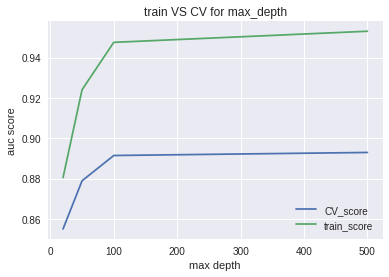

In [0]:
max_depths = [20,50,100,500]
plt.plot(max_depths, CV_scores_depth, label='CV_score')
plt.plot(max_depths, train_scores_depth, label='train_score')
plt.title('train VS CV for max_depth')
plt.ylabel('auc score')
plt.xlabel('max depth')
plt.legend()
plt.show()

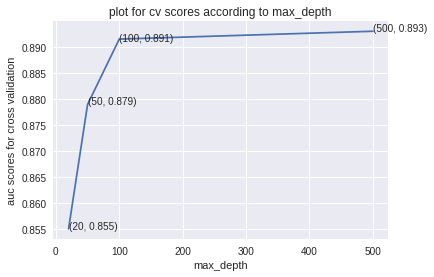

The auc score for each max_depth value for cross validation is :  [0.855 0.879 0.891 0.893]


In [0]:
plt.plot(max_depths, CV_scores_depth)

plt.title('plot for cv scores according to max_depth')
for xy in zip(np.round(max_depths, 2), np.round(CV_scores_depth,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('max_depth')
plt.ylabel('auc scores for cross validation')
plt.show()

print("The auc score for each max_depth value for cross validation is : ", np.round(CV_scores_depth,3))

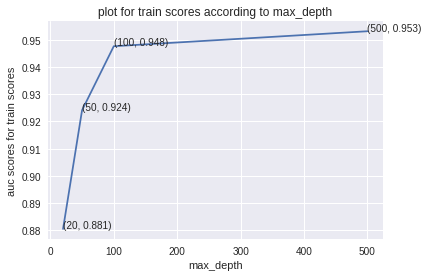

The auc score for each max_depth value for train data is :  [0.881 0.924 0.948 0.953]


In [0]:
plt.plot(max_depths, train_scores_depth)

plt.title('plot for train scores according to max_depth')
for xy in zip(np.round(max_depths, 2), np.round(train_scores_depth,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('max_depth')
plt.ylabel('auc scores for train scores')
plt.show()

print("The auc score for each max_depth value for train data is : ", np.round(train_scores_depth,3))

In [0]:
def scores_for_estimators(X, Y):
    n_estimators=[10,20,40,50]
    scores =[]
    for n_estimator in tqdm(n_estimators):
            clf = RandomForestClassifier(criterion='gini', min_samples_split=10, min_samples_leaf=5, n_estimators=n_estimator, max_depth=500)
            clf.fit(X_train_bow, Y_train)
            pred = clf.predict_proba(X)[:, 1]
            auc = roc_auc_score(Y, pred)
            scores.append(auc)
    return scores

In [0]:
CV_scores_estimators = scores_for_estimators(X_CV_bow, Y_CV)

100%|██████████| 4/4 [03:35<00:00, 53.66s/it]


In [0]:
train_scores_estimators = scores_for_estimators(X_train_bow, Y_train)

100%|██████████| 4/4 [03:40<00:00, 54.69s/it]


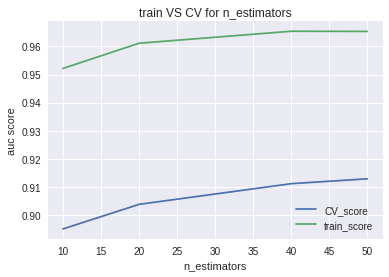

In [0]:
n_estimators=[10,20,40,50]
plt.plot(n_estimators, CV_scores_estimators, label='CV_score')
plt.plot(n_estimators, train_scores_estimators, label='train_score')
plt.title('train VS CV for n_estimators')
plt.ylabel('auc score')
plt.xlabel('n_estimators')
plt.legend()
plt.show()

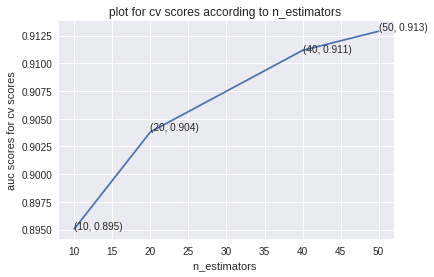

The auc score for each n_estimators  value for cv data is :  [0.895 0.904 0.911 0.913]


In [0]:
plt.plot(n_estimators, CV_scores_estimators)

plt.title('plot for cv scores according to n_estimators ')
for xy in zip(np.round(n_estimators, 2), np.round(CV_scores_estimators,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('n_estimators ')
plt.ylabel('auc scores for cv scores')
plt.show()

print("The auc score for each n_estimators  value for cv data is : ", np.round(CV_scores_estimators,3))

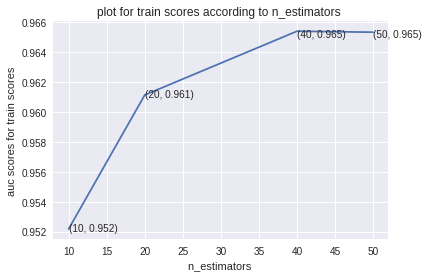

The auc score for each n_estimators  value for train data is :  [0.952 0.961 0.965 0.965]


In [0]:
plt.plot(n_estimators, train_scores_estimators)

plt.title('plot for train scores according to n_estimators ')
for xy in zip(np.round(n_estimators, 2), np.round(train_scores_estimators,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('n_estimators ')
plt.ylabel('auc scores for train scores')
plt.show()

print("The auc score for each n_estimators  value for train data is : ", np.round(train_scores_estimators,3))

## Visualizing the results in 3-D

In [0]:
n_estimators=[10,20,40,50]
max_depths = [20,50,100,500]
scores_for_viz = []
estimator_during_looping = []
depth_during_looping = []
for estimator in tqdm(n_estimators):
  for depth in max_depths:
      RF_model_for_viz = RandomForestClassifier(criterion='gini', min_samples_split=10, min_samples_leaf=5, n_estimators=estimator, max_depth=depth)
      RF_model_for_viz.fit(X_train_bow, Y_train)
      pred = RF_model_for_viz.predict_proba(X_CV_bow)[:, 1] 
      auc = roc_auc_score(Y_CV, pred)
      scores_for_viz.append(auc)
      estimator_during_looping.append(estimator)
      depth_during_looping.append(depth)

100%|██████████| 4/4 [08:33<00:00, 127.33s/it]


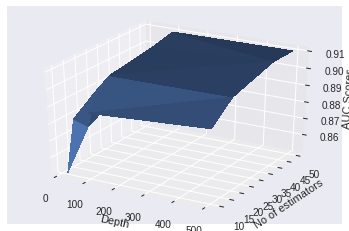

In [0]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Grab some test data.
X = np.asarray(depth_during_looping)
Y = np.asarray(estimator_during_looping)
Z = np.asarray(scores_for_viz)

# Plot a basic wireframe.
ax.plot_trisurf(X, Y, Z, linewidth=0, antialiased=False)
ax.set_xlabel('Depth')
ax.set_ylabel('No of estimators')
ax.set_zlabel('AUC Scores')


plt.show()

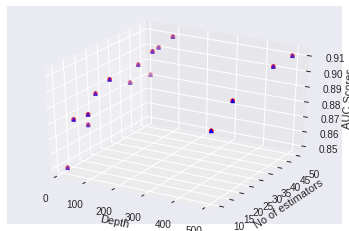

In [0]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, m, zlow, zhigh in [('r', 'o', -50, -25), ('b', '^', -30, -5)]:
    X = np.asarray(depth_during_looping)
    Y = np.asarray(estimator_during_looping)
    Z = np.asarray(scores_for_viz)
    ax.scatter(X, Y, Z, c=c, marker=m)

ax.set_xlabel('Depth')
ax.set_ylabel('No of estimators')
ax.set_zlabel('AUC Scores')

plt.show()

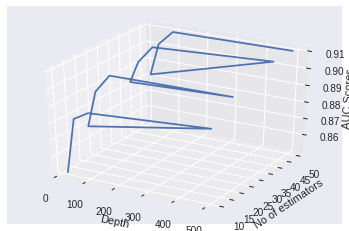

In [0]:
import matplotlib as mpl
mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure()
ax = fig.gca(projection='3d')
X = np.asarray(depth_during_looping)
Y = np.asarray(estimator_during_looping)
Z = np.asarray(scores_for_viz)
ax.plot(X, Y, Z, label='parametric curve')
ax.set_xlabel('Depth')
ax.set_ylabel('No of estimators')
ax.set_zlabel('AUC Scores')

plt.show()

## Getting the test data scores

In [0]:
RF_optimal = RandomForestClassifier(criterion='gini',min_samples_split=10, min_samples_leaf=5,n_estimators=10, max_depth=500)

# fitting the model
RF_optimal.fit(X_train_bow, Y_train)

# predict the response
pred = RF_optimal.predict(X_test_bow)

# evaluate f1_score
fq_score = f1_score(Y_test, pred)

In [0]:
print('\nThe f1 score for test data for max_depth = {} and no of estimators = {} is {:2f}'.format(500, 10, fq_score))


The f1 score for test data for max_depth = 500 and no of estimators = 10 is 0.924016


## Visualizing the results.

In [0]:
conf_matrix = confusion_matrix(Y_test, pred)
conf_matrix

array([[ 1122,  5386],
       [  105, 33387]])

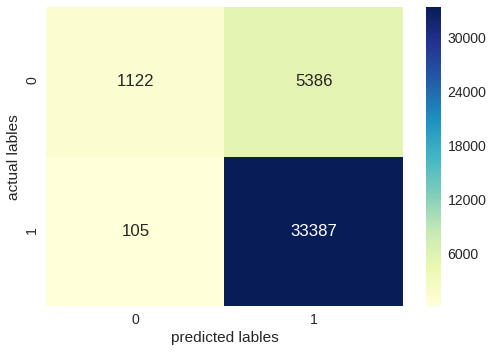

In [0]:
df_cm = pd.DataFrame(conf_matrix, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt="d",cmap="YlGnBu")
plt.xlabel('predicted lables')
plt.ylabel('actual lables')
plt.show()

In [0]:
print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

           0       0.91      0.17      0.29      6508
           1       0.86      1.00      0.92     33492

   micro avg       0.86      0.86      0.86     40000
   macro avg       0.89      0.58      0.61     40000
weighted avg       0.87      0.86      0.82     40000



## Top 20 features

In [0]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.feature_importances_, feature_names))
    top = coefs_with_fns[:-(n + 1):-1]
    words = []
    for (coef_1, fn_1) in top:
       words.append(fn_1)
    return words

In [0]:
words=show_most_informative_features(count_vect, RF_optimal)

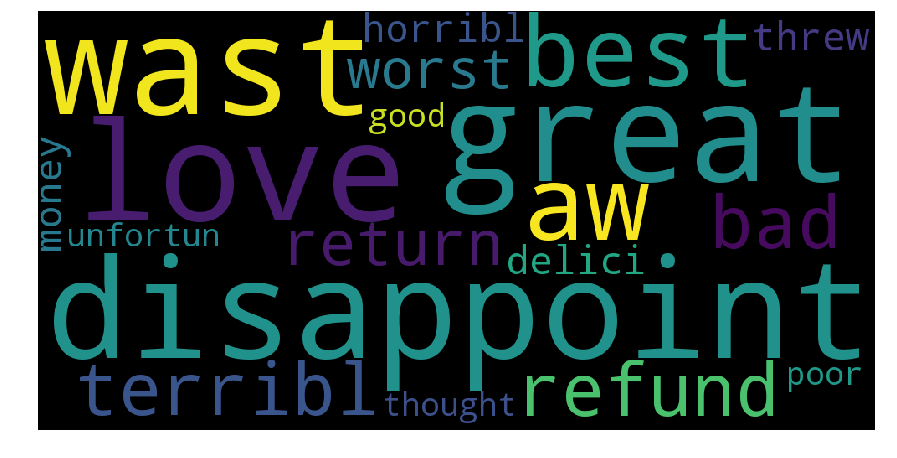

In [0]:
unique_string=(" ").join(words)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("bow"+".png", bbox_inches='tight')
plt.show()
plt.close()

# TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(min_df=50)
X_train_tfidf = tf_idf_vect.fit_transform(X_train['CleanedText'].values)
X_train_tfidf.shape

(120000, 4203)

In [0]:
X_CV_tfidf = tf_idf_vect.transform(X_CV['CleanedText'].values)
X_CV_tfidf.shape

(40000, 4203)

In [0]:
X_test_tfidf = tf_idf_vect.transform(X_test['CleanedText'].values)
X_test_tfidf.shape

(40000, 4203)

# Random Forest implementation on TF-IDF

In [0]:
tuned_parameters = {'n_estimators':[20,40,50,100],  'max_depth':[20,50,100,500]}


RF_model = RandomForestClassifier(criterion='gini', min_samples_split=10, min_samples_leaf=5, oob_score=True)
model = GridSearchCV(RF_model,tuned_parameters,
                     scoring='f1',cv=2,n_jobs=-1)

model.fit(X_train_tfidf, Y_train)

print(model.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=500, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=True, random_state=None, verbose=0, warm_start=False)


## From the above results we can see that optimal number of estimators is 20 and optimal max_depth is 500, now getting the train and cv scores

In [0]:
def scores_for_depth(X, Y):
    max_depths = [20,50,100,500]
    scores =[]
    for max_depth in tqdm(max_depths):
            clf = RandomForestClassifier(criterion='gini', min_samples_split=10, min_samples_leaf=5, n_estimators=20, max_depth=max_depth)
            clf.fit(X_train_tfidf, Y_train)
            pred = clf.predict_proba(X)[:, 1]
            auc = roc_auc_score(Y, pred)
            scores.append(auc)
    return scores

In [0]:
CV_scores_depth = scores_for_depth(X_CV_tfidf, Y_CV)


100%|██████████| 4/4 [00:47<00:00, 11.64s/it]


In [0]:
train_scores_depth = scores_for_depth(X_train_tfidf, Y_train)


100%|██████████| 4/4 [00:52<00:00, 12.92s/it]


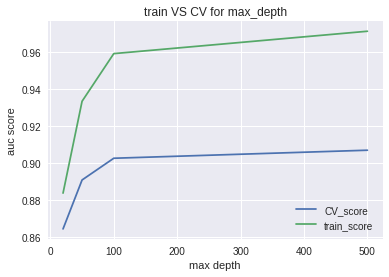

In [0]:
max_depths = [20,50,100,500]
plt.plot(max_depths, CV_scores_depth, label='CV_score')
plt.plot(max_depths, train_scores_depth, label='train_score')
plt.title('train VS CV for max_depth')
plt.ylabel('auc score')
plt.xlabel('max depth')
plt.legend()
plt.show()

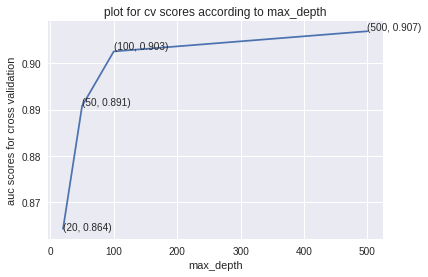

The auc score for each max_depth value for cross validation is :  [0.864 0.891 0.903 0.907]


In [0]:
plt.plot(max_depths, CV_scores_depth)

plt.title('plot for cv scores according to max_depth')
for xy in zip(np.round(max_depths, 2), np.round(CV_scores_depth,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('max_depth')
plt.ylabel('auc scores for cross validation')
plt.show()

print("The auc score for each max_depth value for cross validation is : ", np.round(CV_scores_depth,3))

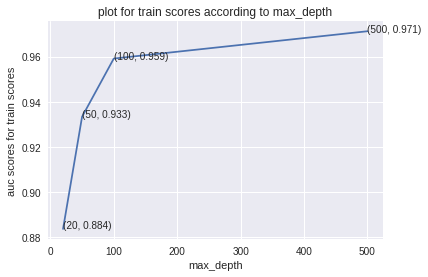

The auc score for each max_depth value for train data is :  [0.884 0.933 0.959 0.971]


In [0]:
plt.plot(max_depths, train_scores_depth)

plt.title('plot for train scores according to max_depth')
for xy in zip(np.round(max_depths, 2), np.round(train_scores_depth,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('max_depth')
plt.ylabel('auc scores for train scores')
plt.show()

print("The auc score for each max_depth value for train data is : ", np.round(train_scores_depth,3))

In [0]:
def scores_for_estimators(X, Y):
    n_estimators=[20,40,50,100]
    scores =[]
    for n_estimator in tqdm(n_estimators):
            clf = RandomForestClassifier(criterion='gini', min_samples_split=10, min_samples_leaf=5, n_estimators=n_estimator, max_depth=500)
            clf.fit(X_train_tfidf, Y_train)
            pred = clf.predict_proba(X)[:, 1]
            auc = roc_auc_score(Y, pred)
            scores.append(auc)
    return scores

In [0]:
CV_scores_estimators = scores_for_estimators(X_CV_tfidf, Y_CV)


100%|██████████| 4/4 [03:43<00:00, 56.79s/it]


In [0]:
train_scores_estimators = scores_for_estimators(X_train_tfidf, Y_train)


100%|██████████| 4/4 [03:59<00:00, 61.20s/it]


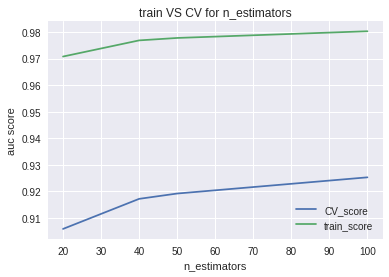

In [0]:
n_estimators=[20,40,50,100]
plt.plot(n_estimators, CV_scores_estimators, label='CV_score')
plt.plot(n_estimators, train_scores_estimators, label='train_score')
plt.title('train VS CV for n_estimators')
plt.ylabel('auc score')
plt.xlabel('n_estimators')
plt.legend()
plt.show()

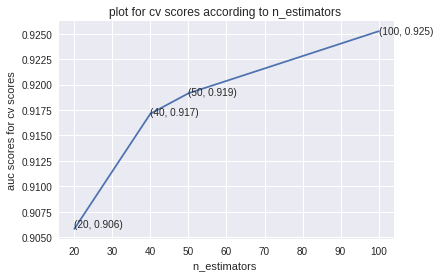

The auc score for each n_estimators  value for cv data is :  [0.906 0.917 0.919 0.925]


In [0]:
plt.plot(n_estimators, CV_scores_estimators)

plt.title('plot for cv scores according to n_estimators ')
for xy in zip(np.round(n_estimators, 2), np.round(CV_scores_estimators,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('n_estimators ')
plt.ylabel('auc scores for cv scores')
plt.show()

print("The auc score for each n_estimators  value for cv data is : ", np.round(CV_scores_estimators,3))

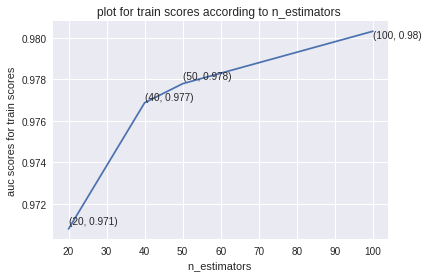

The auc score for each n_estimators  value for train data is :  [0.971 0.977 0.978 0.98 ]


In [0]:
plt.plot(n_estimators, train_scores_estimators)

plt.title('plot for train scores according to n_estimators ')
for xy in zip(np.round(n_estimators, 2), np.round(train_scores_estimators,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('n_estimators ')
plt.ylabel('auc scores for train scores')
plt.show()

print("The auc score for each n_estimators  value for train data is : ", np.round(train_scores_estimators,3))

## Visualizing the results in 3-D

In [0]:
n_estimators=[20,40,50,100]
max_depths = [20,50,100,500]
scores_for_viz = []
estimator_during_looping = []
depth_during_looping = []
for estimator in tqdm(n_estimators):
  for depth in max_depths:
      RF_model_for_viz = RandomForestClassifier(criterion='gini', min_samples_split=10, min_samples_leaf=5, n_estimators=estimator, max_depth=depth)
      RF_model_for_viz.fit(X_train_tfidf, Y_train)
      pred = RF_model_for_viz.predict_proba(X_CV_tfidf)[:, 1] 
      auc = roc_auc_score(Y_CV, pred)
      scores_for_viz.append(auc)
      estimator_during_looping.append(estimator)
      depth_during_looping.append(depth)


100%|██████████| 4/4 [08:36<00:00, 130.84s/it]


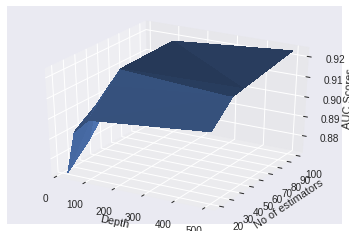

In [0]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Grab some test data.
X = np.asarray(depth_during_looping)
Y = np.asarray(estimator_during_looping)
Z = np.asarray(scores_for_viz)

# Plot a basic wireframe.
ax.plot_trisurf(X, Y, Z, linewidth=0, antialiased=False)
ax.set_xlabel('Depth')
ax.set_ylabel('No of estimators')
ax.set_zlabel('AUC Scores')


plt.show()

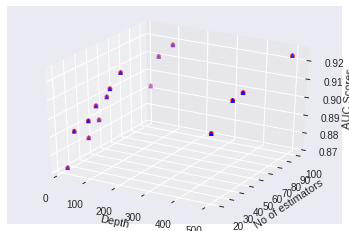

In [0]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, m, zlow, zhigh in [('r', 'o', -50, -25), ('b', '^', -30, -5)]:
    X = np.asarray(depth_during_looping)
    Y = np.asarray(estimator_during_looping)
    Z = np.asarray(scores_for_viz)
    ax.scatter(X, Y, Z, c=c, marker=m)

ax.set_xlabel('Depth')
ax.set_ylabel('No of estimators')
ax.set_zlabel('AUC Scores')

plt.show()

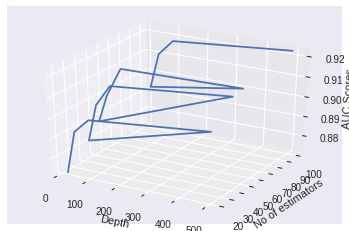

In [0]:
import matplotlib as mpl
mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure()
ax = fig.gca(projection='3d')
X = np.asarray(depth_during_looping)
Y = np.asarray(estimator_during_looping)
Z = np.asarray(scores_for_viz)
ax.plot(X, Y, Z, label='parametric curve')
ax.set_xlabel('Depth')
ax.set_ylabel('No of estimators')
ax.set_zlabel('AUC Scores')

plt.show()

## Getting the test data scores

In [0]:
RF_optimal = RandomForestClassifier(criterion='gini',min_samples_split=10, min_samples_leaf=5,n_estimators=20, max_depth=500)

# fitting the model
RF_optimal.fit(X_train_tfidf, Y_train)

# predict the response
pred = RF_optimal.predict(X_test_tfidf)

# evaluate f1_score
fq_score = f1_score(Y_test, pred)

In [0]:
print('\nThe f1 score for test data for max_depth = {} and no of estimators = {} is {:2f}'.format(500, 20, fq_score))


The f1 score for test data for max_depth = 500 and no of estimators = 20 is 0.914781


## Visualizing the results.

In [0]:
conf_matrix = confusion_matrix(Y_test, pred)
conf_matrix

array([[  275,  6233],
       [    6, 33486]])

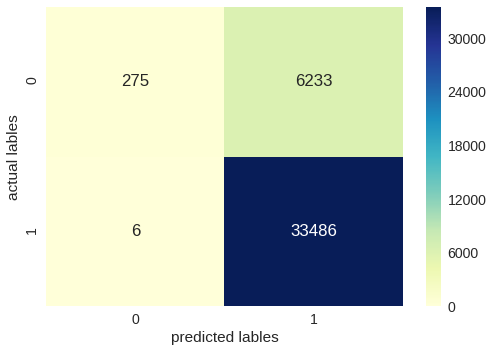

In [0]:
df_cm = pd.DataFrame(conf_matrix, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt="d",cmap="YlGnBu")
plt.xlabel('predicted lables')
plt.ylabel('actual lables')
plt.show()

In [0]:
print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

           0       0.98      0.04      0.08      6508
           1       0.84      1.00      0.91     33492

   micro avg       0.84      0.84      0.84     40000
   macro avg       0.91      0.52      0.50     40000
weighted avg       0.87      0.84      0.78     40000



## Top 20 features

In [0]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.feature_importances_, feature_names))
    top = coefs_with_fns[:-(n + 1):-1]
    words = []
    for (coef_1, fn_1) in top:
       words.append(fn_1)
    return words

In [0]:
words=show_most_informative_features(tf_idf_vect, RF_optimal)

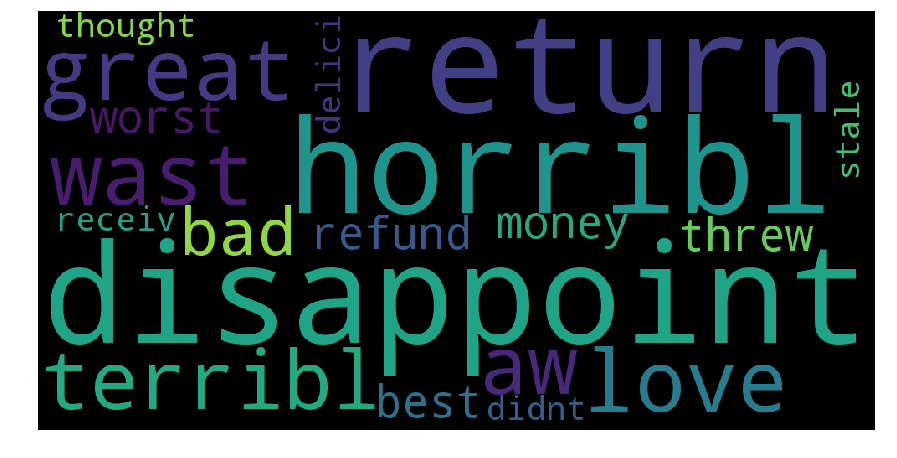

In [0]:
unique_string=(" ").join(words)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("tfidf_RF"+".png", bbox_inches='tight')
plt.show()
plt.close()

# W2V

In [0]:
i=0
list_of_sent =[]
for sent in X_train['Text'].values:
    filtered_sentence =[]
    sent = clean_html(sent)
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sent.append(filtered_sentence)


In [0]:
w2v_model=Word2Vec(list_of_sent, min_count=5 ,size=50)

In [0]:
w2v_words = list(w2v_model.wv.vocab)

# Average W2V

In [0]:
X_train_avgw2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_train_avgw2v.append(sent_vec)
print(len(X_train_avgw2v))
print(len(X_train_avgw2v[0]))

120000
50


In [0]:
X_train_avgw2v = np.asarray(X_train_avgw2v)

In [0]:
X_train_avgw2v = StandardScaler().fit_transform(X_train_avgw2v)

In [0]:
i=0
list_of_sentence =[]
for sent in X_CV['Text'].values:
    filtered_sentence =[]
    sent = clean_html(sent)
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sentence.append(filtered_sentence)

In [0]:
X_CV_avgw2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentence: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_CV_avgw2v.append(sent_vec)
print(len(X_CV_avgw2v))
print(len(X_CV_avgw2v[0]))

40000
50


In [0]:
X_CV_avgw2v = np.asarray(X_CV_avgw2v)
X_CV_avgw2v = StandardScaler().fit_transform(X_CV_avgw2v)
X_CV_avgw2v.shape

(40000, 50)

In [0]:
i=0
list_of_sen =[]
for sent in X_test['Text'].values:
    filtered_sentence =[]
    sent = clean_html(sent)
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sen.append(filtered_sentence)

In [0]:
X_test_avgw2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sen: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_avgw2v.append(sent_vec)
print(len(X_test_avgw2v))
print(len(X_test_avgw2v[0]))

40000
50


In [0]:
X_test_avgw2v = np.asarray(X_test_avgw2v)
X_test_avgw2v = StandardScaler().fit_transform(X_test_avgw2v)
X_test_avgw2v.shape

(40000, 50)

# Random Forest implementation on Average W2V

In [0]:
tuned_parameters = {'n_estimators':[20,40,50,100],  'max_depth':[20,50,100,500]}


RF_model = RandomForestClassifier(criterion='gini', min_samples_split=10, min_samples_leaf=5, oob_score=True)
model = GridSearchCV(RF_model,tuned_parameters,
                     scoring='f1',cv=2,n_jobs=-1)

model.fit(X_train_avgw2v, Y_train)

print(model.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=True, random_state=None, verbose=0, warm_start=False)


## From the above results we can see that optimal number of estimators is 50 and optimal max_depth is 20, now getting the train and cv scores

In [0]:
def scores_for_depth(X, Y):
    max_depths = [20,50,100,500]
    scores =[]
    for max_depth in tqdm(max_depths):
            clf = RandomForestClassifier(criterion='gini', min_samples_split=10, min_samples_leaf=5, n_estimators=50, max_depth=max_depth)
            clf.fit(X_train_avgw2v, Y_train)
            pred = clf.predict_proba(X)[:, 1]
            auc = roc_auc_score(Y, pred)
            scores.append(auc)
    return scores

In [0]:
CV_scores_depth = scores_for_depth(X_CV_avgw2v, Y_CV)

In [0]:
train_scores_depth = scores_for_depth(X_train_avgw2v, Y_train)

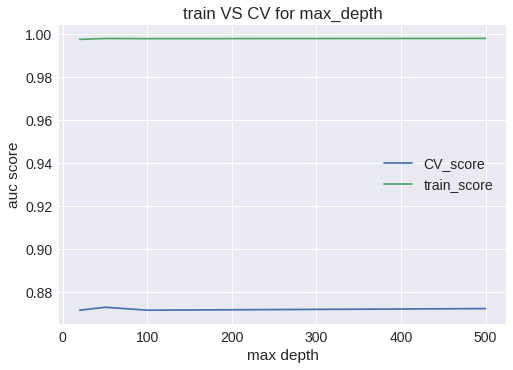

In [0]:
max_depths = [20,50,100,500]
plt.plot(max_depths, CV_scores_depth, label='CV_score')
plt.plot(max_depths, train_scores_depth, label='train_score')
plt.title('train VS CV for max_depth')
plt.ylabel('auc score')
plt.xlabel('max depth')
plt.legend()
plt.show()

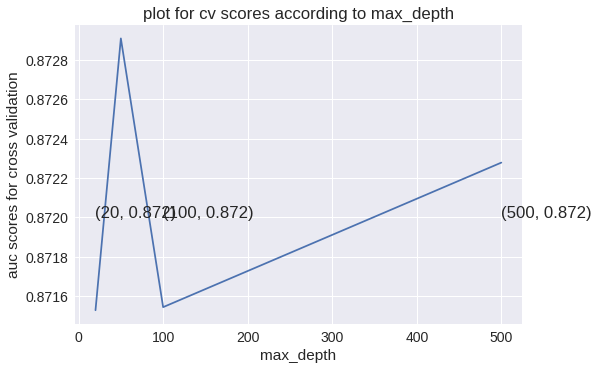

The auc score for each max_depth value for cross validation is :  [0.872 0.873 0.872 0.872]


In [0]:
plt.plot(max_depths, CV_scores_depth)

plt.title('plot for cv scores according to max_depth')
for xy in zip(np.round(max_depths, 2), np.round(CV_scores_depth,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('max_depth')
plt.ylabel('auc scores for cross validation')
plt.show()

print("The auc score for each max_depth value for cross validation is : ", np.round(CV_scores_depth,3))

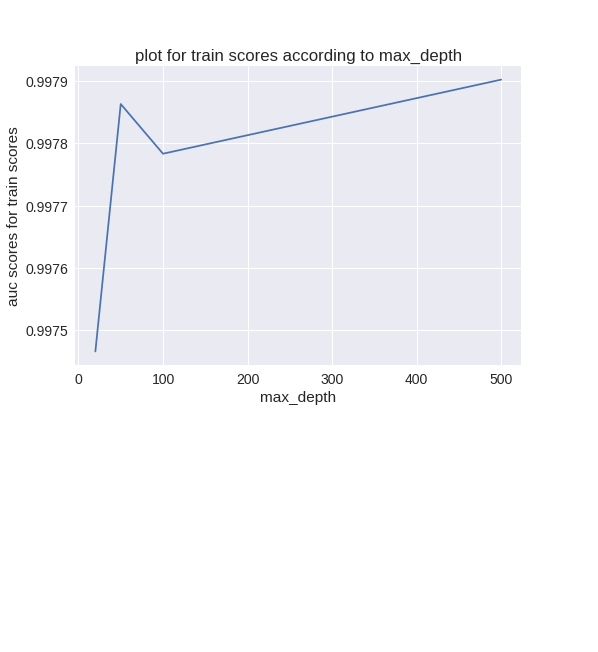

The auc score for each max_depth value for train data is :  [0.997 0.998 0.998 0.998]


In [0]:
plt.plot(max_depths, train_scores_depth)

plt.title('plot for train scores according to max_depth')
for xy in zip(np.round(max_depths, 2), np.round(train_scores_depth,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('max_depth')
plt.ylabel('auc scores for train scores')
plt.show()

print("The auc score for each max_depth value for train data is : ", np.round(train_scores_depth,3))

In [0]:
def scores_for_estimators(X, Y):
    n_estimators=[20,40,50,100]
    scores =[]
    for n_estimator in tqdm(n_estimators):
            clf = RandomForestClassifier(criterion='gini', min_samples_split=10, min_samples_leaf=5, n_estimators=n_estimator, max_depth=500)
            clf.fit(X_train_avgw2v, Y_train)
            pred = clf.predict_proba(X)[:, 1]
            auc = roc_auc_score(Y, pred)
            scores.append(auc)
    return scores

In [0]:
CV_scores_estimators = scores_for_estimators(X_CV_avgw2v, Y_CV)




  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:26<01:18, 26.05s/it]


 50%|█████     | 2/4 [01:17<01:07, 33.54s/it]


 75%|███████▌  | 3/4 [02:18<00:41, 41.85s/it]


100%|██████████| 4/4 [04:23<00:00, 66.82s/it]




In [0]:
train_scores_estimators = scores_for_estimators(X_train_avgw2v, Y_train)




  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [00:25<01:15, 25.20s/it]


 50%|█████     | 2/4 [01:15<01:05, 32.69s/it]


 75%|███████▌  | 3/4 [02:17<00:41, 41.57s/it]


100%|██████████| 4/4 [04:22<00:00, 66.53s/it]




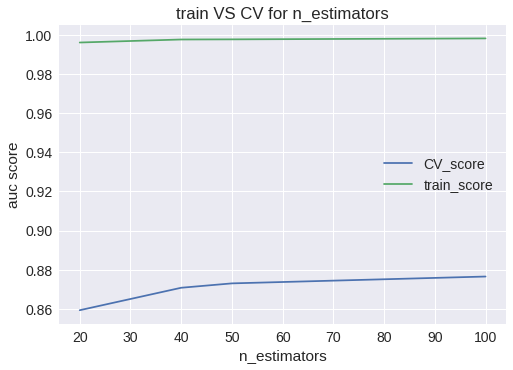

In [0]:
n_estimators=[20,40,50,100]
plt.plot(n_estimators, CV_scores_estimators, label='CV_score')
plt.plot(n_estimators, train_scores_estimators, label='train_score')
plt.title('train VS CV for n_estimators')
plt.ylabel('auc score')
plt.xlabel('n_estimators')
plt.legend()
plt.show()

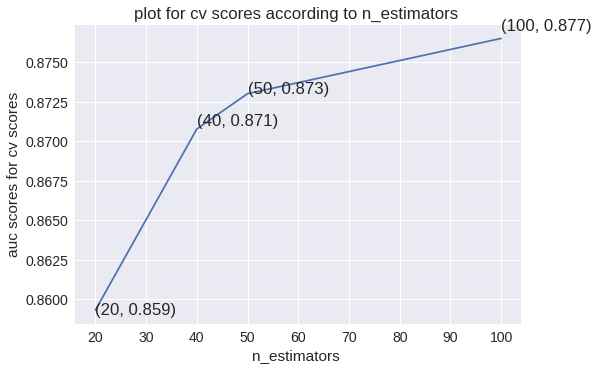

The auc score for each n_estimators  value for cv data is :  [0.859 0.871 0.873 0.877]


In [0]:
plt.plot(n_estimators, CV_scores_estimators)

plt.title('plot for cv scores according to n_estimators ')
for xy in zip(np.round(n_estimators, 2), np.round(CV_scores_estimators,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('n_estimators ')
plt.ylabel('auc scores for cv scores')
plt.show()

print("The auc score for each n_estimators  value for cv data is : ", np.round(CV_scores_estimators,3))

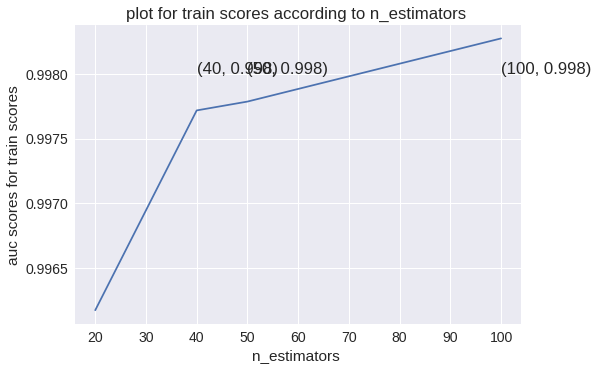

The auc score for each n_estimators  value for train data is :  [0.996 0.998 0.998 0.998]


In [0]:
plt.plot(n_estimators, train_scores_estimators)

plt.title('plot for train scores according to n_estimators ')
for xy in zip(np.round(n_estimators, 2), np.round(train_scores_estimators,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('n_estimators ')
plt.ylabel('auc scores for train scores')
plt.show()

print("The auc score for each n_estimators  value for train data is : ", np.round(train_scores_estimators,3))

## Visualizing the results in 3-D

In [0]:
n_estimators=[10,20,40,50]
max_depths = [20,50,100,500]
scores_for_viz = []
estimator_during_looping = []
depth_during_looping = []
for estimator in tqdm(n_estimators):
  for depth in max_depths:
      RF_model_for_viz = RandomForestClassifier(criterion='gini', min_samples_split=10, min_samples_leaf=5, n_estimators=estimator, max_depth=depth)
      RF_model_for_viz.fit(X_train_avgw2v, Y_train)
      pred = RF_model_for_viz.predict_proba(X_CV_avgw2v)[:, 1] 
      auc = roc_auc_score(Y_CV, pred)
      scores_for_viz.append(auc)
      estimator_during_looping.append(estimator)
      depth_during_looping.append(depth)





  0%|          | 0/4 [00:00<?, ?it/s]



 25%|██▌       | 1/4 [00:49<02:29, 49.92s/it]



 50%|█████     | 2/4 [02:29<02:09, 64.96s/it]



 75%|███████▌  | 3/4 [05:47<01:44, 104.81s/it]



100%|██████████| 4/4 [10:01<00:00, 149.39s/it]





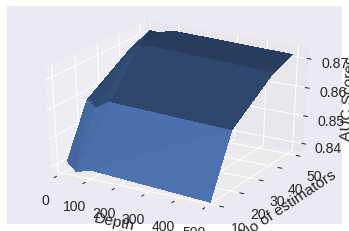

In [0]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Grab some test data.
X = np.asarray(depth_during_looping)
Y = np.asarray(estimator_during_looping)
Z = np.asarray(scores_for_viz)

# Plot a basic wireframe.
ax.plot_trisurf(X, Y, Z, linewidth=0, antialiased=False)
ax.set_xlabel('Depth')
ax.set_ylabel('No of estimators')
ax.set_zlabel('AUC Scores')


plt.show()

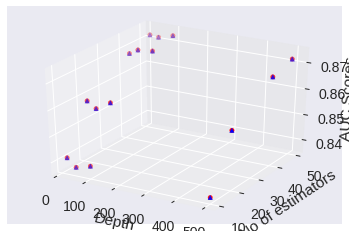

In [0]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, m, zlow, zhigh in [('r', 'o', -50, -25), ('b', '^', -30, -5)]:
    X = np.asarray(depth_during_looping)
    Y = np.asarray(estimator_during_looping)
    Z = np.asarray(scores_for_viz)
    ax.scatter(X, Y, Z, c=c, marker=m)

ax.set_xlabel('Depth')
ax.set_ylabel('No of estimators')
ax.set_zlabel('AUC Scores')

plt.show()

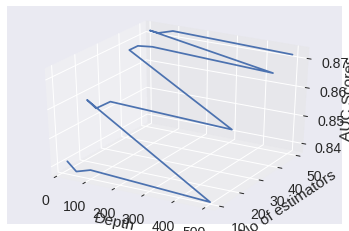

In [0]:
import matplotlib as mpl
mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure()
ax = fig.gca(projection='3d')
X = np.asarray(depth_during_looping)
Y = np.asarray(estimator_during_looping)
Z = np.asarray(scores_for_viz)
ax.plot(X, Y, Z, label='parametric curve')
ax.set_xlabel('Depth')
ax.set_ylabel('No of estimators')
ax.set_zlabel('AUC Scores')

plt.show()

## Getting the test data scores

In [0]:
RF_optimal = RandomForestClassifier(criterion='gini',min_samples_split=10, min_samples_leaf=5,n_estimators=50, max_depth=20)

# fitting the model
RF_optimal.fit(X_train_avgw2v, Y_train)

# predict the response
pred = RF_optimal.predict(X_test_avgw2v)

# evaluate f1_score
fq_score = f1_score(Y_test, pred)

In [0]:
print('\nThe f1 score for test data for max_depth = {} and no of estimators = {} is {:2f}'.format(20, 50, fq_score))


The f1 score for test data for max_depth = 20 and no of estimators = 50 is 0.922078


## Visualizing the results.

In [0]:
conf_matrix = confusion_matrix(Y_test, pred)
conf_matrix

array([[ 1246,  5262],
       [  341, 33151]])

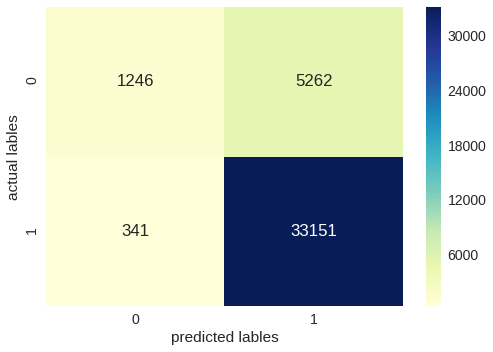

In [0]:
df_cm = pd.DataFrame(conf_matrix, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt="d",cmap="YlGnBu")
plt.xlabel('predicted lables')
plt.ylabel('actual lables')
plt.show()

In [0]:
print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

           0       0.79      0.19      0.31      6508
           1       0.86      0.99      0.92     33492

   micro avg       0.86      0.86      0.86     40000
   macro avg       0.82      0.59      0.61     40000
weighted avg       0.85      0.86      0.82     40000



# TF-IDF W2V

In [0]:
i=0
list_of_sent =[]
for sent in X_train['CleanedText'].values:
    filtered_sentence =[]
    sent = clean_html(sent)
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sent.append(filtered_sentence)


In [0]:
w2v_model=Word2Vec(list_of_sent, min_count=5 ,size=50)

In [0]:
w2v_words = list(w2v_model.wv.vocab)

In [0]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train['CleanedText'].values)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
tfidf_feat = model.get_feature_names()

X_train_tf = []
row=0;
for sent in list_of_sent:  
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_train_tf.append(sent_vec)
    row += 1

In [27]:
X_train_tfidfw2v = np.asarray(X_train_tf)
X_train_tfidfw2v = StandardScaler().fit_transform(X_train_tfidfw2v)
X_train_tfidfw2v.shape

(120000, 50)

In [0]:
i=0
list_of_sentence =[]
for sent in X_CV['CleanedText'].values:
    filtered_sentence =[]
    sent = clean_html(sent)
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sentence.append(filtered_sentence)


In [0]:
X_CV_tfidf = model.transform(X_CV['CleanedText'].values)


In [0]:
tfidf_feat = model.get_feature_names()

X_CV_tf = []
row=0;
for sent in list_of_sentence:  
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_CV_tf.append(sent_vec)
    row += 1

In [31]:
X_CV_tfidfw2v = np.asarray(X_CV_tf)
X_CV_tfidfw2v = StandardScaler().fit_transform(X_CV_tfidfw2v)
X_CV_tfidfw2v.shape

(40000, 50)

In [0]:
i=0
list_of_sen =[]
for sent in X_test['CleanedText'].values:
    filtered_sentence =[]
    sent = clean_html(sent)
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sen.append(filtered_sentence)

In [0]:
X_test_tfidf = model.transform(X_test['CleanedText'].values)


In [0]:
tfidf_feat = model.get_feature_names()

X_test_tf = []
row=0;
for sent in list_of_sen:  
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_test_tf.append(sent_vec)
    row += 1

In [35]:
X_test_tfidfw2v = np.asarray(X_test_tf)
X_test_tfidfw2v = StandardScaler().fit_transform(X_test_tfidfw2v)
X_test_tfidfw2v.shape

(40000, 50)

# Random Forest implementation on TF-IDF weighted W2V

In [0]:
tuned_parameters = {'n_estimators':[10,20,40,50],  'max_depth':[20,50,100,500]}


RF_model = RandomForestClassifier(criterion='gini', min_samples_split=10, min_samples_leaf=5, oob_score=True)
model = GridSearchCV(RF_model,tuned_parameters,
                     scoring='f1',cv=2,n_jobs=-1)

model.fit(X_train_tfidfw2v, Y_train)

print(model.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=True, random_state=None, verbose=0, warm_start=False)


## From the above results we can see that optimal number of estimators is 50 and optimal max_depth is 50, now getting the train and cv scores

In [0]:
def scores_for_depth(X, Y):
    max_depths = [20,50,100,500]
    scores =[]
    for max_depth in tqdm(max_depths):
            clf = RandomForestClassifier(criterion='gini', min_samples_split=10, min_samples_leaf=5, n_estimators=50, max_depth=max_depth, oob_score=True)
            clf.fit(X_train_tfidfw2v, Y_train)
            pred = clf.predict_proba(X)[:, 1]
            auc = roc_auc_score(Y, pred)
            scores.append(auc)
    return scores

In [0]:
CV_scores_depth = scores_for_depth(X_CV_tfidfw2v, Y_CV)





  0%|          | 0/4 [00:00<?, ?it/s]



 25%|██▌       | 1/4 [01:08<03:25, 68.36s/it]



 50%|█████     | 2/4 [02:15<02:16, 68.13s/it]



 75%|███████▌  | 3/4 [03:21<01:07, 67.50s/it]



100%|██████████| 4/4 [04:28<00:00, 67.24s/it]





In [0]:
train_scores_depth = scores_for_depth(X_train_tfidfw2v, Y_train)





  0%|          | 0/4 [00:00<?, ?it/s]



 25%|██▌       | 1/4 [01:06<03:20, 66.73s/it]



 50%|█████     | 2/4 [02:15<02:14, 67.49s/it]



 75%|███████▌  | 3/4 [03:22<01:07, 67.23s/it]



100%|██████████| 4/4 [04:29<00:00, 66.99s/it]





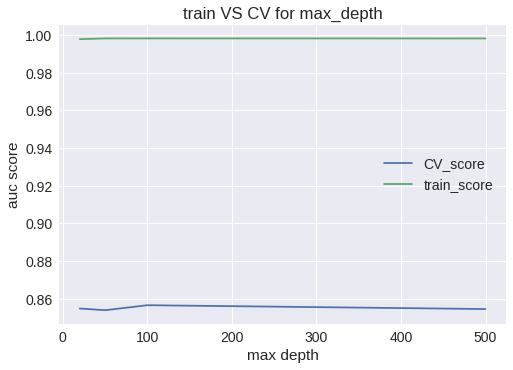

In [0]:
max_depths = [20,50,100,500]
plt.plot(max_depths, CV_scores_depth, label='CV_score')
plt.plot(max_depths, train_scores_depth, label='train_score')
plt.title('train VS CV for max_depth')
plt.ylabel('auc score')
plt.xlabel('max depth')
plt.legend()
plt.show()

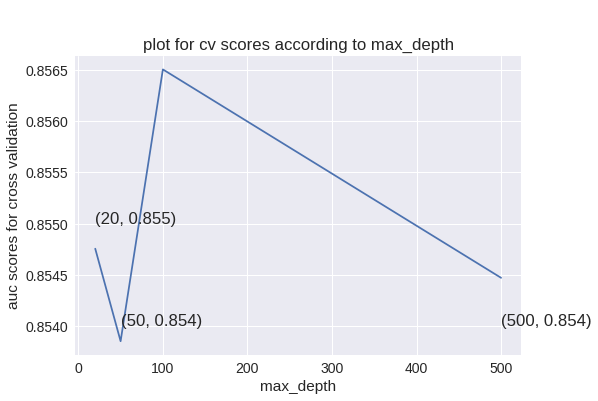

The auc score for each max_depth value for cross validation is :  [0.855 0.854 0.857 0.854]


In [0]:
plt.plot(max_depths, CV_scores_depth)

plt.title('plot for cv scores according to max_depth')
for xy in zip(np.round(max_depths, 2), np.round(CV_scores_depth,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('max_depth')
plt.ylabel('auc scores for cross validation')
plt.show()

print("The auc score for each max_depth value for cross validation is : ", np.round(CV_scores_depth,3))

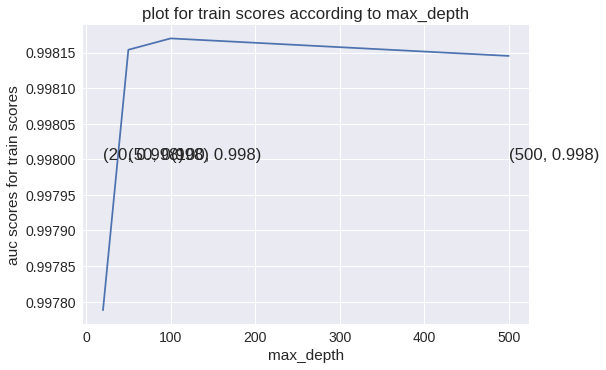

The auc score for each max_depth value for train data is :  [0.998 0.998 0.998 0.998]


In [0]:
plt.plot(max_depths, train_scores_depth)

plt.title('plot for train scores according to max_depth')
for xy in zip(np.round(max_depths, 2), np.round(train_scores_depth,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('max_depth')
plt.ylabel('auc scores for train scores')
plt.show()

print("The auc score for each max_depth value for train data is : ", np.round(train_scores_depth,3))

In [0]:
def scores_for_estimators(X, Y):
    n_estimators=[10,20,40,50]
    scores =[]
    for n_estimator in tqdm(n_estimators):
            clf = RandomForestClassifier(criterion='gini', min_samples_split=10, min_samples_leaf=5, n_estimators=n_estimator, max_depth=50, oob_score=True)
            clf.fit(X_train_tfidfw2v, Y_train)
            pred = clf.predict_proba(X)[:, 1]
            auc = roc_auc_score(Y, pred)
            scores.append(auc)
    return scores

In [0]:
CV_scores_estimators = scores_for_estimators(X_CV_tfidfw2v, Y_CV)





  0%|          | 0/4 [00:00<?, ?it/s]



 25%|██▌       | 1/4 [00:13<00:40, 13.34s/it]



 50%|█████     | 2/4 [00:40<00:34, 17.42s/it]



 75%|███████▌  | 3/4 [01:32<00:27, 27.94s/it]



100%|██████████| 4/4 [02:38<00:00, 39.41s/it]





In [0]:
train_scores_estimators = scores_for_estimators(X_train_tfidfw2v, Y_train)





  0%|          | 0/4 [00:00<?, ?it/s]



 25%|██▌       | 1/4 [00:13<00:39, 13.03s/it]



 50%|█████     | 2/4 [00:40<00:34, 17.29s/it]



 75%|███████▌  | 3/4 [01:33<00:28, 28.20s/it]



100%|██████████| 4/4 [02:42<00:00, 40.37s/it]





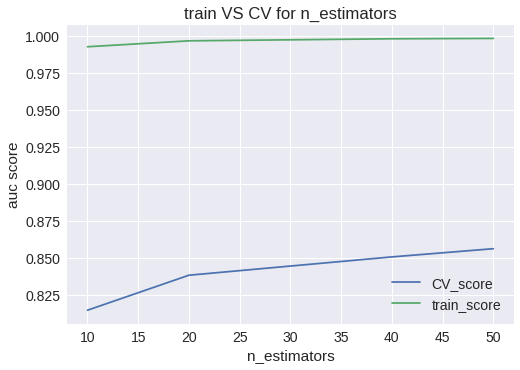

In [0]:
n_estimators=[10,20,40,50]
plt.plot(n_estimators, CV_scores_estimators, label='CV_score')
plt.plot(n_estimators, train_scores_estimators, label='train_score')
plt.title('train VS CV for n_estimators')
plt.ylabel('auc score')
plt.xlabel('n_estimators')
plt.legend()
plt.show()

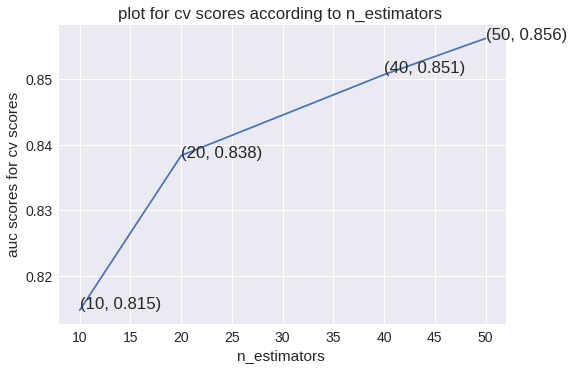

The auc score for each n_estimators  value for cv data is :  [0.815 0.838 0.851 0.856]


In [0]:
plt.plot(n_estimators, CV_scores_estimators)

plt.title('plot for cv scores according to n_estimators ')
for xy in zip(np.round(n_estimators, 2), np.round(CV_scores_estimators,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('n_estimators ')
plt.ylabel('auc scores for cv scores')
plt.show()

print("The auc score for each n_estimators  value for cv data is : ", np.round(CV_scores_estimators,3))

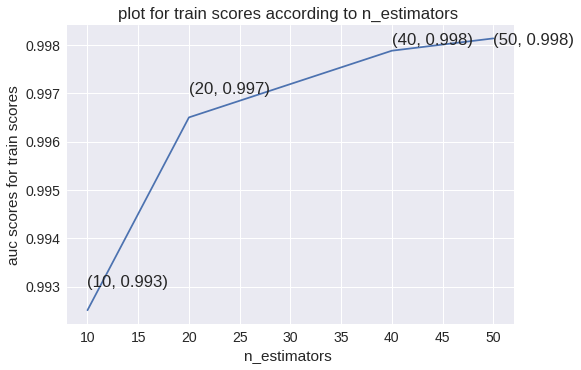

The auc score for each n_estimators  value for train data is :  [0.993 0.997 0.998 0.998]


In [0]:
plt.plot(n_estimators, train_scores_estimators)

plt.title('plot for train scores according to n_estimators ')
for xy in zip(np.round(n_estimators, 2), np.round(train_scores_estimators,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('n_estimators ')
plt.ylabel('auc scores for train scores')
plt.show()

print("The auc score for each n_estimators  value for train data is : ", np.round(train_scores_estimators,3))

## Visualizing the results in 3-D

In [0]:
n_estimators=[10,20,40,50]
max_depths = [20,50,100,500]
scores_for_viz = []
estimator_during_looping = []
depth_during_looping = []
for estimator in tqdm(n_estimators):
  for depth in max_depths:
      RF_model_for_viz = RandomForestClassifier(criterion='gini', min_samples_split=10, min_samples_leaf=5, n_estimators=estimator, max_depth=depth)
      RF_model_for_viz.fit(X_train_tfidfw2v, Y_train)
      pred = RF_model_for_viz.predict_proba(X_CV_tfidfw2v)[:, 1] 
      auc = roc_auc_score(Y_CV, pred)
      scores_for_viz.append(auc)
      estimator_during_looping.append(estimator)
      depth_during_looping.append(depth)





  0%|          | 0/4 [00:00<?, ?it/s]



 25%|██▌       | 1/4 [00:52<02:38, 52.68s/it]



 50%|█████     | 2/4 [02:37<02:16, 68.23s/it]



 75%|███████▌  | 3/4 [06:06<01:50, 110.67s/it]



100%|██████████| 4/4 [10:28<00:00, 155.82s/it]





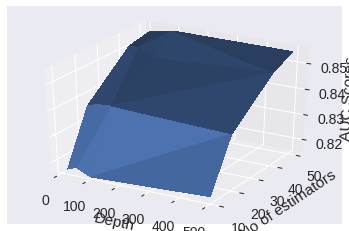

In [0]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Grab some test data.
X = np.asarray(depth_during_looping)
Y = np.asarray(estimator_during_looping)
Z = np.asarray(scores_for_viz)

# Plot a basic wireframe.
ax.plot_trisurf(X, Y, Z, linewidth=0, antialiased=False)
ax.set_xlabel('Depth')
ax.set_ylabel('No of estimators')
ax.set_zlabel('AUC Scores')


plt.show()

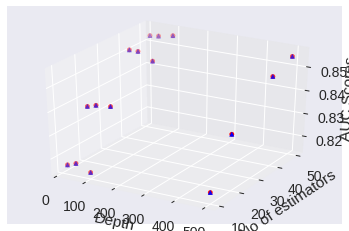

In [0]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, m, zlow, zhigh in [('r', 'o', -50, -25), ('b', '^', -30, -5)]:
    X = np.asarray(depth_during_looping)
    Y = np.asarray(estimator_during_looping)
    Z = np.asarray(scores_for_viz)
    ax.scatter(X, Y, Z, c=c, marker=m)

ax.set_xlabel('Depth')
ax.set_ylabel('No of estimators')
ax.set_zlabel('AUC Scores')

plt.show()

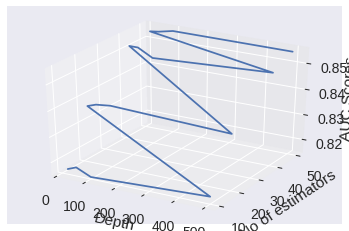

In [0]:
import matplotlib as mpl
mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure()
ax = fig.gca(projection='3d')
X = np.asarray(depth_during_looping)
Y = np.asarray(estimator_during_looping)
Z = np.asarray(scores_for_viz)
ax.plot(X, Y, Z, label='parametric curve')
ax.set_xlabel('Depth')
ax.set_ylabel('No of estimators')
ax.set_zlabel('AUC Scores')

plt.show()

## Getting the test data scores

In [0]:
RF_optimal = RandomForestClassifier(criterion='gini',min_samples_split=10, min_samples_leaf=5,n_estimators=50, max_depth=50, oob_score=True)

# fitting the model
RF_optimal.fit(X_train_tfidfw2v, Y_train)

# predict the response
pred = RF_optimal.predict(X_test_tfidfw2v)

# evaluate f1_score
fq_score = f1_score(Y_test, pred)

In [0]:
print('\nThe f1 score for test data for max_depth = {} and no of estimators = {} is {:2f}'.format(50, 50, fq_score))


The f1 score for test data for max_depth = 50 and no of estimators = 50 is 0.921250


## Visualizing the resluts.

In [0]:
conf_matrix = confusion_matrix(Y_test, pred)
conf_matrix

array([[ 1028,  5480],
       [  210, 33282]])

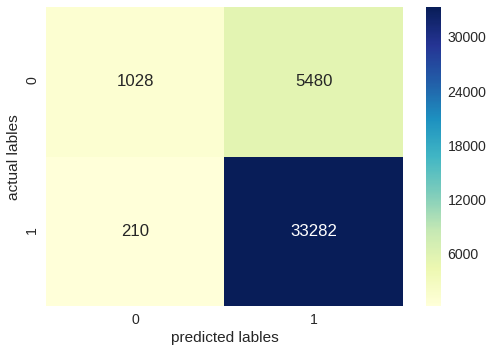

In [0]:
df_cm = pd.DataFrame(conf_matrix, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt="d",cmap="YlGnBu")
plt.xlabel('predicted lables')
plt.ylabel('actual lables')
plt.show()

In [0]:
print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

           0       0.83      0.16      0.27      6508
           1       0.86      0.99      0.92     33492

   micro avg       0.86      0.86      0.86     40000
   macro avg       0.84      0.58      0.59     40000
weighted avg       0.85      0.86      0.81     40000



# Comparison of all the models.

In [0]:
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Max Depth", "No of estimators", "f1-Score on the test data"]
x.add_row(['BOW', 'Random Forest', 500, 10, '0.9240'])
x.add_row(['TF-IDF', 'Random Forest', 500, 20, '0.9147'])
x.add_row(['Average W2V', 'Random Forest',20, 50, '0.9220'])
x.add_row(['TF-IDF Weighted W2V', 'Random Forest', 50, 50, '0.9212'])
print(x)

+---------------------+---------------+-----------+------------------+---------------------------+
|      Vectorizer     |     Model     | Max Depth | No of estimators | f1-Score on the test data |
+---------------------+---------------+-----------+------------------+---------------------------+
|         BOW         | Random Forest |    500    |        10        |           0.9240          |
|        TF-IDF       | Random Forest |    500    |        20        |           0.9147          |
|     Average W2V     | Random Forest |     20    |        50        |           0.9220          |
| TF-IDF Weighted W2V | Random Forest |     50    |        50        |           0.9212          |
+---------------------+---------------+-----------+------------------+---------------------------+


## Thus, from the above table we can see that the model with BOW vectorizer performed better.

# GBDT on BOW

In [0]:
tuned_parameters = {'n_estimators':[10,20,40,50],  'learning_rate':[10**-3,10**-2,10**-1,1,10,100]}


GBDT_model = GradientBoostingClassifier(loss='deviance', min_samples_split=10, min_samples_leaf=5)
model = GridSearchCV(GBDT_model,tuned_parameters,
                     scoring='f1',cv=2,n_jobs=-1)

model.fit(X_train_bow, Y_train)

print(model.best_estimator_)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=5, min_samples_split=10,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


## From the above results we can see that the optimal no of estimator will be 50 and optimal learning_rate is 1, now getting the train and CV scores

In [0]:
def scores_for_lr(X, Y):
    lrs = [10**-3,10**-2,10**-1,1,10,100]
    scores =[]
    for lr in tqdm(lrs):
            clf = GradientBoostingClassifier(loss='deviance', min_samples_split=10, min_samples_leaf=5, n_estimators=50, learning_rate=lr)
            clf.fit(X_train_bow, Y_train)
            pred = clf.predict_proba(X)[:, 1]
            auc = roc_auc_score(Y, pred)
            scores.append(auc)
    return scores

In [0]:
CV_scores_lr = scores_for_lr(X_CV_bow, Y_CV)

100%|██████████| 6/6 [04:29<00:00, 45.74s/it]


In [0]:
train_scores_lr = scores_for_lr(X_train_bow, Y_train)

100%|██████████| 6/6 [04:33<00:00, 45.92s/it]


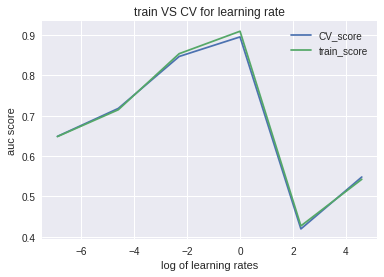

In [0]:
lrs = [10**-3,10**-2,10**-1,1,10,100]
log_lrs = np.log(np.asarray(lrs))
plt.plot(log_lrs, CV_scores_lr, label='CV_score')
plt.plot(log_lrs, train_scores_lr, label='train_score')
plt.title('train VS CV for learning rate')
plt.ylabel('auc score')
plt.xlabel('log of learning rates')
plt.legend()
plt.show()

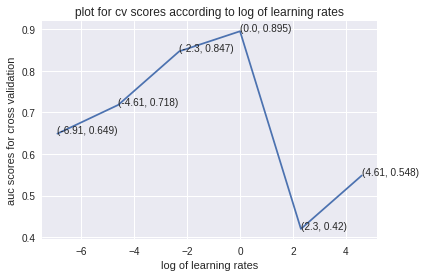

The auc score for each log of learning rates value for cross validation is :  [0.649 0.718 0.847 0.895 0.42  0.548]


In [0]:
plt.plot(log_lrs, CV_scores_lr)

plt.title('plot for cv scores according to log of learning rates')
for xy in zip(np.round(log_lrs, 2), np.round(CV_scores_lr,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log of learning rates')
plt.ylabel('auc scores for cross validation')
plt.show()

print("The auc score for each log of learning rates value for cross validation is : ", np.round(CV_scores_lr,3))

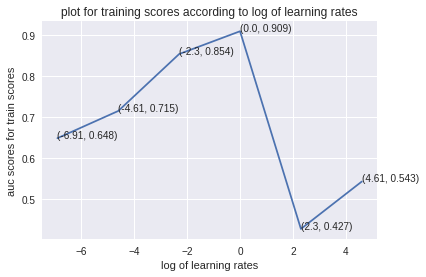

The auc score for each log of learning rates value for train data is :  [0.648 0.715 0.854 0.909 0.427 0.543]


In [0]:
plt.plot(log_lrs, train_scores_lr)

plt.title('plot for training scores according to log of learning rates')
for xy in zip(np.round(log_lrs, 2), np.round(train_scores_lr,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log of learning rates')
plt.ylabel('auc scores for train scores')
plt.show()

print("The auc score for each log of learning rates value for train data is : ", np.round(train_scores_lr,3))

In [0]:
def scores_for_estimators(X, Y):
    n_estimators=[10,20,40,50]
    scores =[]
    for n_estimator in tqdm(n_estimators):
            clf = GradientBoostingClassifier(loss='deviance', min_samples_split=10, min_samples_leaf=5, learning_rate=1, n_estimators=n_estimator)
            clf.fit(X_train_bow, Y_train)
            pred = clf.predict_proba(X)[:, 1]
            auc = roc_auc_score(Y, pred)
            scores.append(auc)
    return scores

In [0]:
CV_scores_estimators = scores_for_estimators(X_CV_bow, Y_CV)

100%|██████████| 4/4 [01:47<00:00, 26.91s/it]


In [0]:
train_scores_estimators = scores_for_estimators(X_train_bow, Y_train)

100%|██████████| 4/4 [01:46<00:00, 26.47s/it]


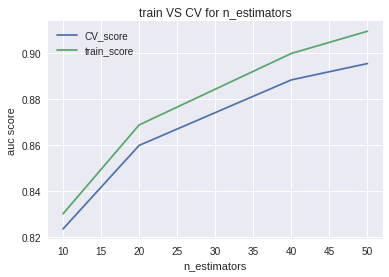

In [0]:
n_estimators=[10,20,40,50]
plt.plot(n_estimators, CV_scores_estimators, label='CV_score')
plt.plot(n_estimators, train_scores_estimators, label='train_score')
plt.title('train VS CV for n_estimators')
plt.ylabel('auc score')
plt.xlabel('n_estimators')
plt.legend()
plt.show()

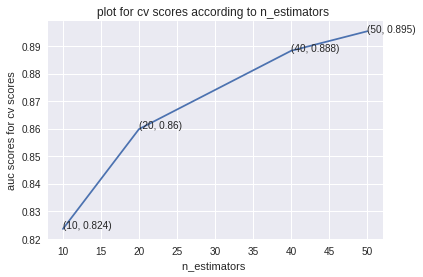

The auc score for each n_estimators  value for cv data is :  [0.824 0.86  0.888 0.895]


In [0]:
plt.plot(n_estimators, CV_scores_estimators)

plt.title('plot for cv scores according to n_estimators ')
for xy in zip(np.round(n_estimators, 2), np.round(CV_scores_estimators,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('n_estimators ')
plt.ylabel('auc scores for cv scores')
plt.show()

print("The auc score for each n_estimators  value for cv data is : ", np.round(CV_scores_estimators,3))

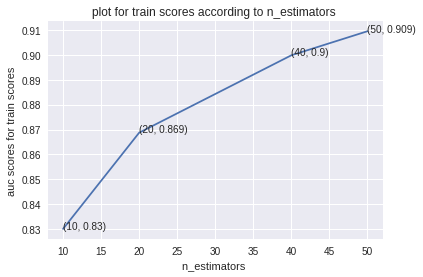

The auc score for each n_estimators  value for train data is :  [0.83  0.869 0.9   0.909]


In [0]:
plt.plot(n_estimators, train_scores_estimators)

plt.title('plot for train scores according to n_estimators ')
for xy in zip(np.round(n_estimators, 2), np.round(train_scores_estimators,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('n_estimators ')
plt.ylabel('auc scores for train scores')
plt.show()

print("The auc score for each n_estimators  value for train data is : ", np.round(train_scores_estimators,3))

## Visualizing the results in 3-D

In [0]:
n_estimators=[10,20,40,50]
lrs = [10**-3,10**-2,10**-1,1,10,100]
scores_for_viz = []
estimator_during_looping = []
lr_during_looping = []
for estimator in tqdm(n_estimators):
  for lr in lrs:
      gbdt_model_for_viz = GradientBoostingClassifier(loss='deviance', min_samples_split=10, min_samples_leaf=5, learning_rate=lr, n_estimators=estimator)
      gbdt_model_for_viz.fit(X_train_bow, Y_train)
      pred = gbdt_model_for_viz.predict_proba(X_CV_bow)[:, 1] 
      auc = roc_auc_score(Y_CV, pred)
      scores_for_viz.append(auc)
      estimator_during_looping.append(estimator)
      lr_during_looping.append(lr)
      

100%|██████████| 4/4 [10:49<00:00, 160.83s/it]


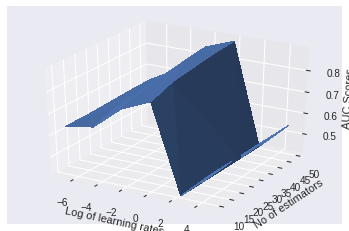

In [0]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Grab some test data.
X = np.log(np.asarray(lr_during_looping))
Y = np.asarray(estimator_during_looping)
Z = np.asarray(scores_for_viz)

# Plot a basic wireframe.
ax.plot_trisurf(X, Y, Z, linewidth=0, antialiased=False)
ax.set_xlabel('Log of learning rates')
ax.set_ylabel('No of estimators')
ax.set_zlabel('AUC Scores')


plt.show()

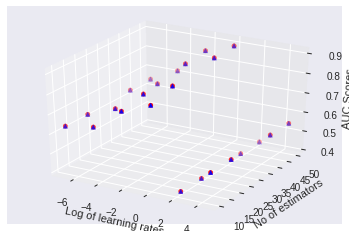

In [0]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, m, zlow, zhigh in [('r', 'o', -50, -25), ('b', '^', -30, -5)]:
    X = np.log(np.asarray(lr_during_looping))
    Y = np.asarray(estimator_during_looping)
    Z = np.asarray(scores_for_viz)
    ax.scatter(X, Y, Z, c=c, marker=m)

ax.set_xlabel('Log of learning rates')
ax.set_ylabel('No of estimators')
ax.set_zlabel('AUC Scores')

plt.show()

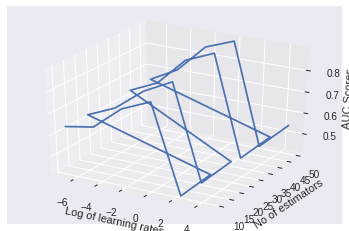

In [0]:
import matplotlib as mpl
mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure()
ax = fig.gca(projection='3d')
X = np.log(np.asarray(lr_during_looping))
Y = np.asarray(estimator_during_looping)
Z = np.asarray(scores_for_viz)
ax.plot(X, Y, Z, label='parametric curve')
ax.set_xlabel('Log of learning rates')
ax.set_ylabel('No of estimators')
ax.set_zlabel('AUC Scores')

plt.show()

## Getting the test data scores

In [0]:
gbdt_optimal = GradientBoostingClassifier(loss='deviance', min_samples_split=10, min_samples_leaf=5, learning_rate=1, n_estimators=50)

# fitting the model
gbdt_optimal.fit(X_train_bow, Y_train)

# predict the response
pred = gbdt_optimal.predict(X_test_bow)

# evaluate f1_score
fq_score = f1_score(Y_test, pred)

In [0]:
print('\nThe f1 score for test data for learning rate = {} and no of estimators = {} is {:2f}'.format(1, 50, fq_score))


The f1 score for test data for learning rate = 1 and no of estimators = 50 is 0.937527


## Visualizing the results.


In [0]:
conf_matrix = confusion_matrix(Y_test, pred)
conf_matrix

array([[ 3316,  3192],
       [ 1122, 32370]])

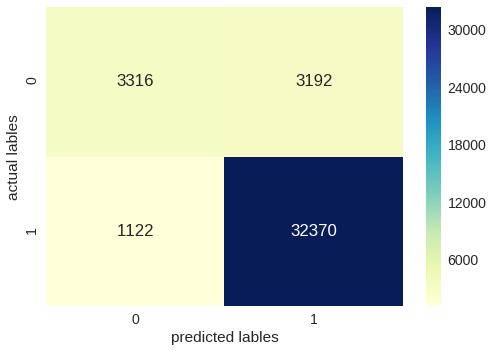

In [0]:
df_cm = pd.DataFrame(conf_matrix, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt="d",cmap="YlGnBu")
plt.xlabel('predicted lables')
plt.ylabel('actual lables')
plt.show()

In [0]:
print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

           0       0.75      0.51      0.61      6508
           1       0.91      0.97      0.94     33492

   micro avg       0.89      0.89      0.89     40000
   macro avg       0.83      0.74      0.77     40000
weighted avg       0.88      0.89      0.88     40000



## Top 20 features

In [0]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.feature_importances_, feature_names))
    top = coefs_with_fns[:-(n + 1):-1]
    words = []
    for (coef_1, fn_1) in top:
       words.append(fn_1)
    return words

In [0]:
words=show_most_informative_features(count_vect, gbdt_optimal)

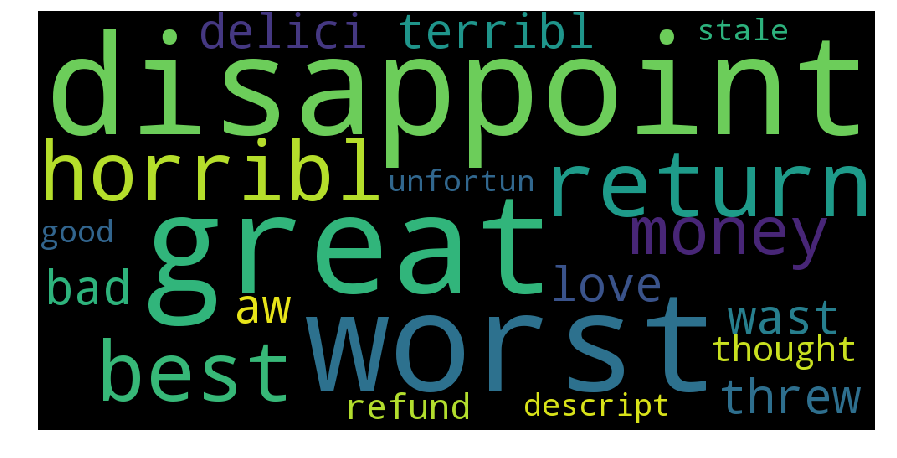

In [0]:
unique_string=(" ").join(words)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("bow_gbdt"+".png", bbox_inches='tight')
plt.show()
plt.close()

# GBDT implementation on TF-IDF

In [0]:
tuned_parameters = {'n_estimators':[10,20,40,50], 'learning_rate':[10**-3,10**-2,10**-1,1,10,100]}


GBDT_model = GradientBoostingClassifier(loss='deviance', min_samples_split=10, min_samples_leaf=5)
model = GridSearchCV(GBDT_model,tuned_parameters,
                     scoring='f1',cv=2,n_jobs=-1)

model.fit(X_train_tfidf, Y_train)

print(model.best_estimator_)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=5, min_samples_split=10,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


## From the above results we can see that the optimal no of estimator will be 50 and optimal learning_rate is 1, now getting the train and CV scores

In [0]:
def scores_for_lr(X, Y):
    lrs = [10**-3,10**-2,10**-1,1,10,100]
    scores =[]
    for lr in tqdm(lrs):
            clf = GradientBoostingClassifier(loss='deviance', min_samples_split=10, min_samples_leaf=5, n_estimators=50, learning_rate=lr)
            clf.fit(X_train_tfidf, Y_train)
            pred = clf.predict_proba(X)[:, 1]
            auc = roc_auc_score(Y, pred)
            scores.append(auc)
    return scores

In [0]:
CV_scores_lr = scores_for_lr(X_CV_tfidf, Y_CV)

100%|██████████| 6/6 [13:01<00:00, 129.04s/it]


In [0]:
train_scores_lr = scores_for_lr(X_train_tfidf, Y_train)

100%|██████████| 6/6 [13:19<00:00, 132.41s/it]


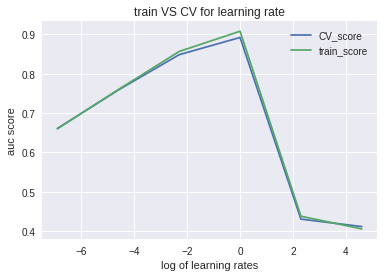

In [0]:
lrs = [10**-3,10**-2,10**-1,1,10,100]
log_lrs = np.log(np.asarray(lrs))
plt.plot(log_lrs, CV_scores_lr, label='CV_score')
plt.plot(log_lrs, train_scores_lr, label='train_score')
plt.title('train VS CV for learning rate')
plt.ylabel('auc score')
plt.xlabel('log of learning rates')
plt.legend()
plt.show()

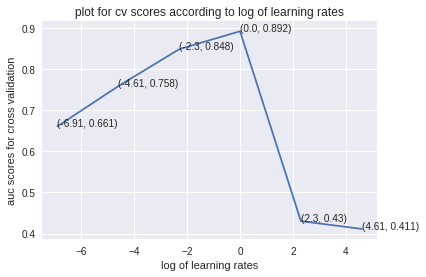

The auc score for each log of learning rates value for cross validation is :  [0.661 0.758 0.848 0.892 0.43  0.411]


In [0]:
plt.plot(log_lrs, CV_scores_lr)

plt.title('plot for cv scores according to log of learning rates')
for xy in zip(np.round(log_lrs, 2), np.round(CV_scores_lr,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log of learning rates')
plt.ylabel('auc scores for cross validation')
plt.show()

print("The auc score for each log of learning rates value for cross validation is : ", np.round(CV_scores_lr,3))

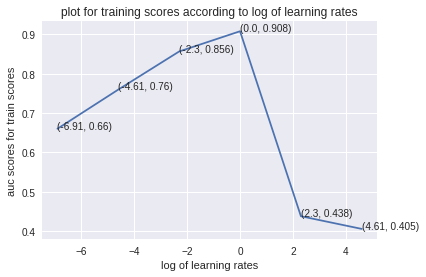

The auc score for each log of learning rates value for train data is :  [0.66  0.76  0.856 0.908 0.438 0.405]


In [0]:
plt.plot(log_lrs, train_scores_lr)

plt.title('plot for training scores according to log of learning rates')
for xy in zip(np.round(log_lrs, 2), np.round(train_scores_lr,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log of learning rates')
plt.ylabel('auc scores for train scores')
plt.show()

print("The auc score for each log of learning rates value for train data is : ", np.round(train_scores_lr,3))

In [0]:
def scores_for_estimators(X, Y):
    n_estimators=[10,20,40,50]
    scores =[]
    for n_estimator in tqdm(n_estimators):
            clf = GradientBoostingClassifier(loss='deviance', min_samples_split=10, min_samples_leaf=5, learning_rate=1, n_estimators=n_estimator)
            clf.fit(X_train_tfidf, Y_train)
            pred = clf.predict_proba(X)[:, 1]
            auc = roc_auc_score(Y, pred)
            scores.append(auc)
    return scores

In [0]:
CV_scores_estimators = scores_for_estimators(X_CV_tfidf, Y_CV)

100%|██████████| 4/4 [05:18<00:00, 78.86s/it]


In [0]:
train_scores_estimators = scores_for_estimators(X_train_tfidf, Y_train)

100%|██████████| 4/4 [05:21<00:00, 80.01s/it]


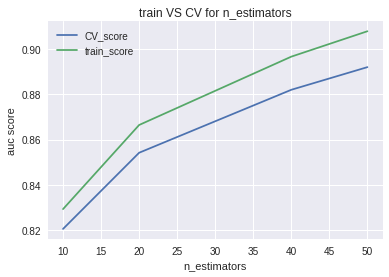

In [0]:
n_estimators=[10,20,40,50]
plt.plot(n_estimators, CV_scores_estimators, label='CV_score')
plt.plot(n_estimators, train_scores_estimators, label='train_score')
plt.title('train VS CV for n_estimators')
plt.ylabel('auc score')
plt.xlabel('n_estimators')
plt.legend()
plt.show()

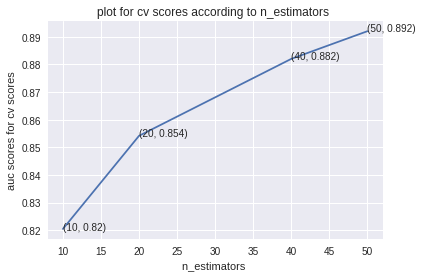

The auc score for each n_estimators  value for cv data is :  [0.82  0.854 0.882 0.892]


In [0]:
plt.plot(n_estimators, CV_scores_estimators)

plt.title('plot for cv scores according to n_estimators ')
for xy in zip(np.round(n_estimators, 2), np.round(CV_scores_estimators,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('n_estimators ')
plt.ylabel('auc scores for cv scores')
plt.show()

print("The auc score for each n_estimators  value for cv data is : ", np.round(CV_scores_estimators,3))

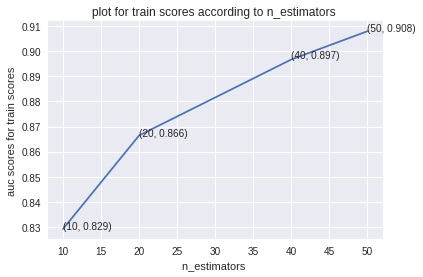

The auc score for each n_estimators  value for train data is :  [0.829 0.866 0.897 0.908]


In [0]:
plt.plot(n_estimators, train_scores_estimators)

plt.title('plot for train scores according to n_estimators ')
for xy in zip(np.round(n_estimators, 2), np.round(train_scores_estimators,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('n_estimators ')
plt.ylabel('auc scores for train scores')
plt.show()

print("The auc score for each n_estimators  value for train data is : ", np.round(train_scores_estimators,3))

## Visualizing the results in 3-D.

In [0]:
n_estimators=[10,20,40,50]
lrs = [10**-3,10**-2,10**-1,1,10,100]
scores_for_viz = []
estimator_during_looping = []
lr_during_looping = []
for estimator in tqdm(n_estimators):
  for lr in lrs:
      gbdt_model_for_viz = GradientBoostingClassifier(loss='deviance', min_samples_split=10, min_samples_leaf=5, learning_rate=lr, n_estimators=estimator)
      gbdt_model_for_viz.fit(X_train_tfidf, Y_train)
      pred = gbdt_model_for_viz.predict_proba(X_CV_tfidf)[:, 1] 
      auc = roc_auc_score(Y_CV, pred)
      scores_for_viz.append(auc)
      estimator_during_looping.append(estimator)
      lr_during_looping.append(lr)
      

100%|██████████| 4/4 [32:07<00:00, 477.13s/it]


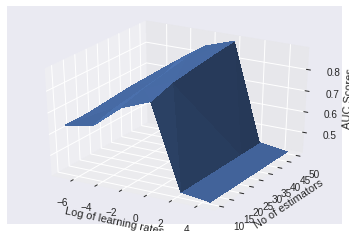

In [0]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Grab some test data.
X = np.log(np.asarray(lr_during_looping))
Y = np.asarray(estimator_during_looping)
Z = np.asarray(scores_for_viz)

# Plot a basic wireframe.
ax.plot_trisurf(X, Y, Z, linewidth=0, antialiased=False)
ax.set_xlabel('Log of learning rates')
ax.set_ylabel('No of estimators')
ax.set_zlabel('AUC Scores')


plt.show()

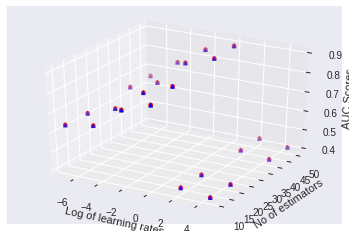

In [0]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, m, zlow, zhigh in [('r', 'o', -50, -25), ('b', '^', -30, -5)]:
    X = np.log(np.asarray(lr_during_looping))
    Y = np.asarray(estimator_during_looping)
    Z = np.asarray(scores_for_viz)
    ax.scatter(X, Y, Z, c=c, marker=m)

ax.set_xlabel('Log of learning rates')
ax.set_ylabel('No of estimators')
ax.set_zlabel('AUC Scores')

plt.show()

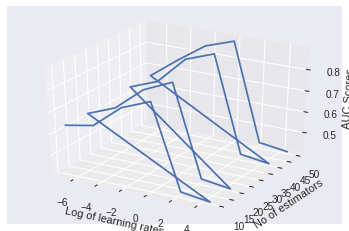

In [0]:
import matplotlib as mpl
mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure()
ax = fig.gca(projection='3d')
X = np.log(np.asarray(lr_during_looping))
Y = np.asarray(estimator_during_looping)
Z = np.asarray(scores_for_viz)
ax.plot(X, Y, Z, label='parametric curve')
ax.set_xlabel('Log of learning rates')
ax.set_ylabel('No of estimators')
ax.set_zlabel('AUC Scores')

plt.show()

## Getting the test data scores

In [0]:
gbdt_optimal = GradientBoostingClassifier(loss='deviance', min_samples_split=10, min_samples_leaf=5, learning_rate=1, n_estimators=50)

# fitting the model
gbdt_optimal.fit(X_train_tfidf, Y_train)

# predict the response
pred = gbdt_optimal.predict(X_test_tfidf)

# evaluate f1_score
fq_score = f1_score(Y_test, pred)

In [0]:
print('\nThe f1 score for test data for learning rate = {} and no of estimators = {} is {:2f}'.format(1, 50, fq_score))


The f1 score for test data for learning rate = 1 and no of estimators = 50 is 0.934566


## Visualizing the results.

In [0]:
conf_matrix = confusion_matrix(Y_test, pred)
conf_matrix

array([[ 3340,  3168],
       [ 1335, 32157]])

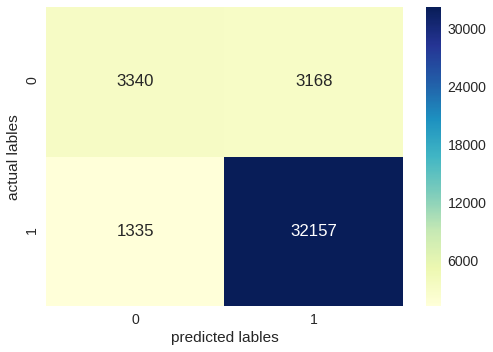

In [0]:
df_cm = pd.DataFrame(conf_matrix, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt="d",cmap="YlGnBu")
plt.xlabel('predicted lables')
plt.ylabel('actual lables')
plt.show()

In [0]:
print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

           0       0.71      0.51      0.60      6508
           1       0.91      0.96      0.93     33492

   micro avg       0.89      0.89      0.89     40000
   macro avg       0.81      0.74      0.77     40000
weighted avg       0.88      0.89      0.88     40000



## Top 20 features

In [0]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.feature_importances_, feature_names))
    top = coefs_with_fns[:-(n + 1):-1]
    words = []
    for (coef_1, fn_1) in top:
       words.append(fn_1)
    return words

In [0]:
words=show_most_informative_features(tf_idf_vect, gbdt_optimal)

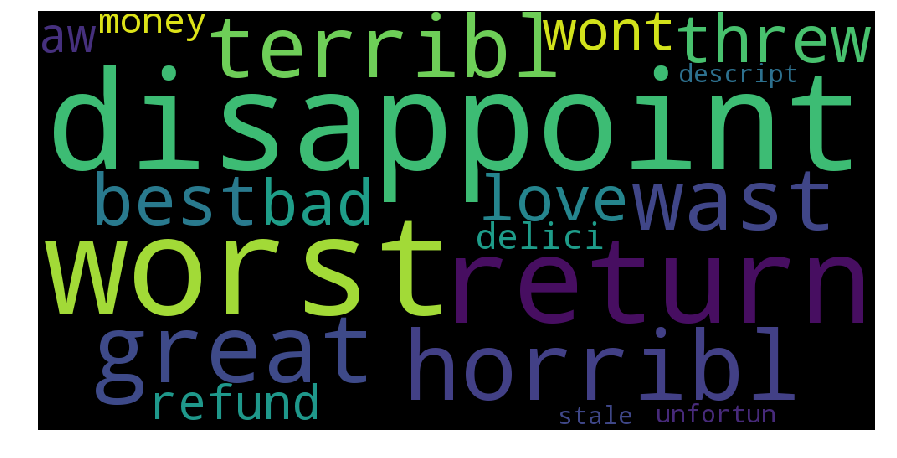

In [0]:
unique_string=(" ").join(words)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("tfidf_gbdt"+".png", bbox_inches='tight')
plt.show()
plt.close()

# GBDT implementation on Average W2V

In [0]:
tuned_parameters = {'n_estimators':[10,20,40,50],  'learning_rate':[10**-3,10**-2,10**-1,1,10,100]}


GBDT_model = GradientBoostingClassifier(loss='deviance', min_samples_split=10, min_samples_leaf=5)
model = GridSearchCV(GBDT_model,tuned_parameters,
                     scoring='f1',cv=2,n_jobs=-1)

model.fit(X_train_avgw2v, Y_train)

print(model.best_estimator_)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=5, min_samples_split=10,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


## From the above results we can see that the optimal no of estimator will be 50 and optimal learning_rate is 0.1, now getting the train and CV scores

In [0]:
def scores_for_lr(X, Y):
    lrs = [10**-3,10**-2,10**-1,1,10,100]
    scores =[]
    for lr in tqdm(lrs):
            clf = GradientBoostingClassifier(loss='deviance', min_samples_split=10, min_samples_leaf=5, n_estimators=50, learning_rate=lr)
            clf.fit(X_train_avgw2v, Y_train)
            pred = clf.predict_proba(X)[:, 1]
            auc = roc_auc_score(Y, pred)
            scores.append(auc)
    return scores

In [0]:
CV_scores_lr = scores_for_lr(X_CV_avgw2v, Y_CV)



  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [01:17<06:28, 77.75s/it]

 33%|███▎      | 2/6 [02:37<05:13, 78.28s/it]

 50%|█████     | 3/6 [03:58<03:57, 79.09s/it]

 67%|██████▋   | 4/6 [05:14<02:36, 78.33s/it]

 83%|████████▎ | 5/6 [06:32<01:18, 78.03s/it]

100%|██████████| 6/6 [07:51<00:00, 78.29s/it]



In [0]:
train_scores_lr = scores_for_lr(X_train_avgw2v, Y_train)



  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [01:16<06:20, 76.16s/it]

 33%|███▎      | 2/6 [02:34<05:07, 76.83s/it]

 50%|█████     | 3/6 [03:58<03:56, 78.90s/it]

 67%|██████▋   | 4/6 [05:14<02:35, 77.96s/it]

 83%|████████▎ | 5/6 [06:34<01:18, 78.61s/it]

100%|██████████| 6/6 [07:52<00:00, 78.53s/it]



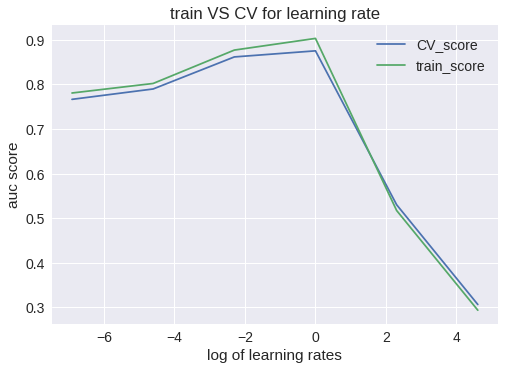

In [0]:
lrs = [10**-3,10**-2,10**-1,1,10,100]
log_lrs = np.log(np.asarray(lrs))
plt.plot(log_lrs, CV_scores_lr, label='CV_score')
plt.plot(log_lrs, train_scores_lr, label='train_score')
plt.title('train VS CV for learning rate')
plt.ylabel('auc score')
plt.xlabel('log of learning rates')
plt.legend()
plt.show()

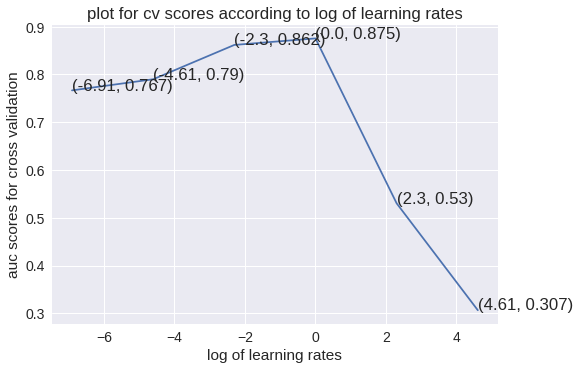

The auc score for each log of learning rates value for cross validation is :  [0.767 0.79  0.862 0.875 0.53  0.307]


In [0]:
plt.plot(log_lrs, CV_scores_lr)

plt.title('plot for cv scores according to log of learning rates')
for xy in zip(np.round(log_lrs, 2), np.round(CV_scores_lr,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log of learning rates')
plt.ylabel('auc scores for cross validation')
plt.show()

print("The auc score for each log of learning rates value for cross validation is : ", np.round(CV_scores_lr,3))

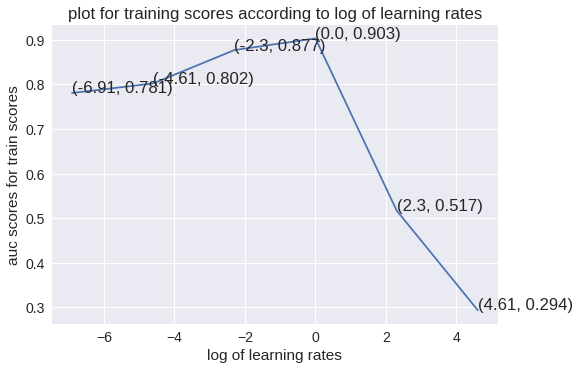

The auc score for each log of learning rates value for train data is :  [0.781 0.802 0.877 0.903 0.517 0.294]


In [0]:
plt.plot(log_lrs, train_scores_lr)

plt.title('plot for training scores according to log of learning rates')
for xy in zip(np.round(log_lrs, 2), np.round(train_scores_lr,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log of learning rates')
plt.ylabel('auc scores for train scores')
plt.show()

print("The auc score for each log of learning rates value for train data is : ", np.round(train_scores_lr,3))

In [0]:
def scores_for_estimators(X, Y):
    n_estimators=[10,20,40,50]
    scores =[]
    for n_estimator in tqdm(n_estimators):
            clf = GradientBoostingClassifier(loss='deviance', min_samples_split=10, min_samples_leaf=5, learning_rate=0.1, n_estimators=n_estimator)
            clf.fit(X_train_avgw2v, Y_train)
            pred = clf.predict_proba(X)[:, 1]
            auc = roc_auc_score(Y, pred)
            scores.append(auc)
    return scores

In [0]:
CV_scores_estimators = scores_for_estimators(X_CV_avgw2v, Y_CV)



  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:16<00:49, 16.59s/it]

 50%|█████     | 2/4 [00:48<00:42, 21.27s/it]

 75%|███████▌  | 3/4 [01:44<00:31, 31.71s/it]

100%|██████████| 4/4 [03:00<00:00, 44.85s/it]



In [0]:
train_scores_estimators = scores_for_estimators(X_train_avgw2v, Y_train)



  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:16<00:50, 16.98s/it]

 50%|█████     | 2/4 [00:50<00:43, 21.81s/it]

 75%|███████▌  | 3/4 [01:53<00:34, 34.24s/it]

100%|██████████| 4/4 [03:11<00:00, 47.39s/it]



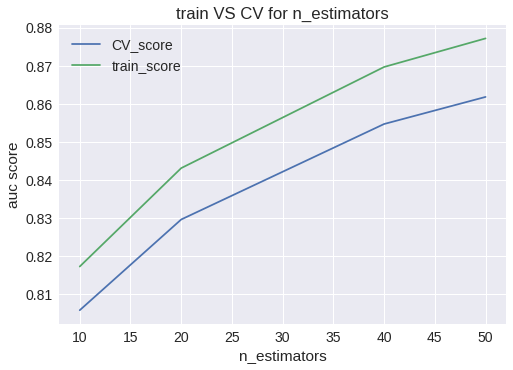

In [0]:
n_estimators=[10,20,40,50]
plt.plot(n_estimators, CV_scores_estimators, label='CV_score')
plt.plot(n_estimators, train_scores_estimators, label='train_score')
plt.title('train VS CV for n_estimators')
plt.ylabel('auc score')
plt.xlabel('n_estimators')
plt.legend()
plt.show()

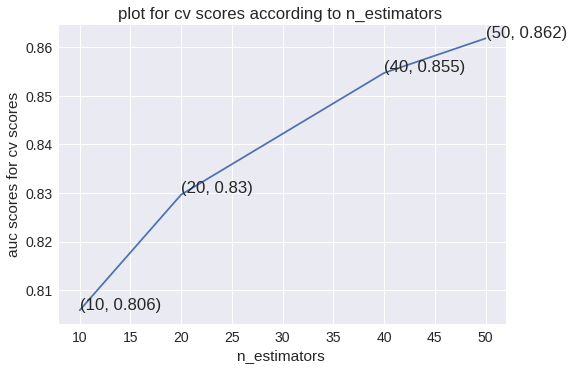

The auc score for each n_estimators  value for cv data is :  [0.806 0.83  0.855 0.862]


In [0]:
plt.plot(n_estimators, CV_scores_estimators)

plt.title('plot for cv scores according to n_estimators ')
for xy in zip(np.round(n_estimators, 2), np.round(CV_scores_estimators,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('n_estimators ')
plt.ylabel('auc scores for cv scores')
plt.show()

print("The auc score for each n_estimators  value for cv data is : ", np.round(CV_scores_estimators,3))

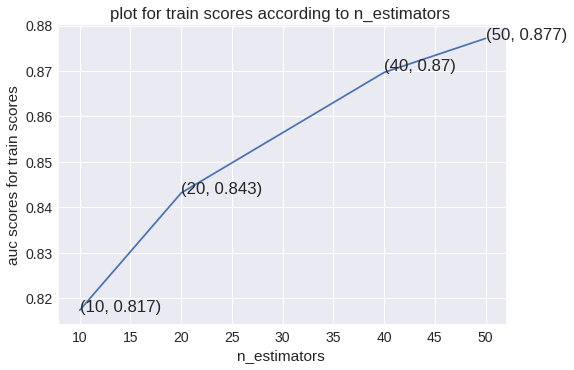

The auc score for each n_estimators  value for train data is :  [0.817 0.843 0.87  0.877]


In [0]:
plt.plot(n_estimators, train_scores_estimators)

plt.title('plot for train scores according to n_estimators ')
for xy in zip(np.round(n_estimators, 2), np.round(train_scores_estimators,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('n_estimators ')
plt.ylabel('auc scores for train scores')
plt.show()

print("The auc score for each n_estimators  value for train data is : ", np.round(train_scores_estimators,3))

## Visualizing the results in 3-D

In [0]:
n_estimators=[10,20,40,50]
lrs = [10**-3,10**-2,10**-1,1,10,100]
scores_for_viz = []
estimator_during_looping = []
lr_during_looping = []
for estimator in tqdm(n_estimators):
  for lr in lrs:
      gbdt_model_for_viz = GradientBoostingClassifier(loss='deviance', min_samples_split=10, min_samples_leaf=5, learning_rate=lr, n_estimators=estimator)
      gbdt_model_for_viz.fit(X_train_avgw2v, Y_train)
      pred = gbdt_model_for_viz.predict_proba(X_CV_avgw2v)[:, 1] 
      auc = roc_auc_score(Y_CV, pred)
      scores_for_viz.append(auc)
      estimator_during_looping.append(estimator)
      lr_during_looping.append(lr)
      



  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [01:34<04:43, 94.35s/it]

 50%|█████     | 2/4 [04:45<04:06, 123.42s/it]

 75%|███████▌  | 3/4 [10:53<03:16, 196.88s/it]

100%|██████████| 4/4 [18:17<00:00, 270.91s/it]



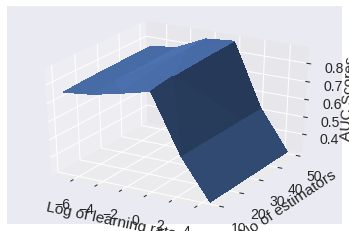

In [0]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Grab some test data.
X = np.log(np.asarray(lr_during_looping))
Y = np.asarray(estimator_during_looping)
Z = np.asarray(scores_for_viz)

# Plot a basic wireframe.
ax.plot_trisurf(X, Y, Z, linewidth=0, antialiased=False)
ax.set_xlabel('Log of learning rates')
ax.set_ylabel('No of estimators')
ax.set_zlabel('AUC Scores')


plt.show()

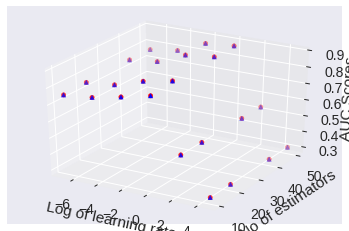

In [0]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, m, zlow, zhigh in [('r', 'o', -50, -25), ('b', '^', -30, -5)]:
    X = np.log(np.asarray(lr_during_looping))
    Y = np.asarray(estimator_during_looping)
    Z = np.asarray(scores_for_viz)
    ax.scatter(X, Y, Z, c=c, marker=m)

ax.set_xlabel('Log of learning rates')
ax.set_ylabel('No of estimators')
ax.set_zlabel('AUC Scores')

plt.show()

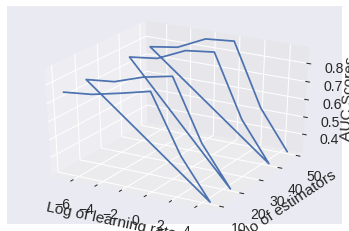

In [0]:
import matplotlib as mpl
mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure()
ax = fig.gca(projection='3d')
X = np.log(np.asarray(lr_during_looping))
Y = np.asarray(estimator_during_looping)
Z = np.asarray(scores_for_viz)
ax.plot(X, Y, Z, label='parametric curve')
ax.set_xlabel('Log of learning rates')
ax.set_ylabel('No of estimators')
ax.set_zlabel('AUC Scores')

plt.show()

## Getting the test data scores

In [0]:
gbdt_optimal = GradientBoostingClassifier(loss='deviance', min_samples_split=10, min_samples_leaf=5, learning_rate=0.1, n_estimators=50)

# fitting the model
gbdt_optimal.fit(X_train_avgw2v, Y_train)

# predict the response
pred = gbdt_optimal.predict(X_test_avgw2v)

# evaluate f1_score
fq_score = f1_score(Y_test, pred)

In [0]:
print('\nThe f1 score for test data for learning rate = {} and no of estimators = {} is {:2f}'.format(0.1, 50, fq_score))


The f1 score for test data for learning rate = 0.1 and no of estimators = 50 is 0.919065


## Visualizing the results in 3-D.

In [0]:
conf_matrix = confusion_matrix(Y_test, pred)
conf_matrix

array([[ 1082,  5426],
       [  402, 33090]])

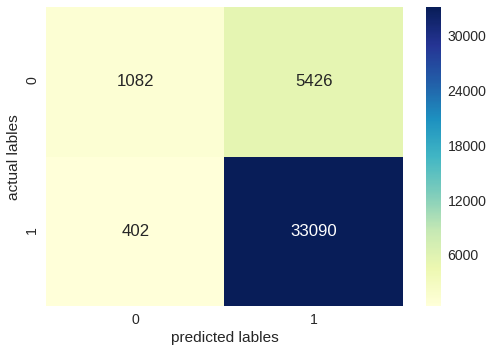

In [0]:
df_cm = pd.DataFrame(conf_matrix, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt="d",cmap="YlGnBu")
plt.xlabel('predicted lables')
plt.ylabel('actual lables')
plt.show()

In [0]:
print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

           0       0.73      0.17      0.27      6508
           1       0.86      0.99      0.92     33492

   micro avg       0.85      0.85      0.85     40000
   macro avg       0.79      0.58      0.59     40000
weighted avg       0.84      0.85      0.81     40000



# GBDT implementation on tf-idf weighted W2V

In [0]:
tuned_parameters = {'n_estimators':[10,20,40,50],  'learning_rate':[10**-3,10**-2,10**-1,1,10,100]}


GBDT_model = GradientBoostingClassifier(loss='deviance', min_samples_split=10, min_samples_leaf=5)
model = GridSearchCV(GBDT_model,tuned_parameters,
                     scoring='f1',cv=2,n_jobs=-1)

model.fit(X_train_tfidfw2v, Y_train)

print(model.best_estimator_)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=5, min_samples_split=10,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


## From the above results we can see that the optimal no of estimator will be 50 and optimal learning_rate is 0.1, now getting the train and CV scores

In [0]:
def scores_for_lr(X, Y):
    lrs = [10**-3,10**-2,10**-1,1,10,100]
    scores =[]
    for lr in tqdm(lrs):
            clf = GradientBoostingClassifier(loss='deviance', min_samples_split=10, min_samples_leaf=5, n_estimators=50, learning_rate=lr)
            clf.fit(X_train_tfidfw2v, Y_train)
            pred = clf.predict_proba(X)[:, 1]
            auc = roc_auc_score(Y, pred)
            scores.append(auc)
    return scores

In [37]:
CV_scores_lr = scores_for_lr(X_CV_tfidfw2v, Y_CV)

100%|██████████| 6/6 [06:42<00:00, 67.45s/it]


In [38]:
train_scores_lr = scores_for_lr(X_train_tfidfw2v, Y_train)

100%|██████████| 6/6 [06:41<00:00, 67.10s/it]


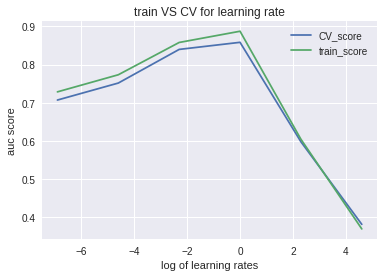

In [39]:
lrs = [10**-3,10**-2,10**-1,1,10,100]
log_lrs = np.log(np.asarray(lrs))
plt.plot(log_lrs, CV_scores_lr, label='CV_score')
plt.plot(log_lrs, train_scores_lr, label='train_score')
plt.title('train VS CV for learning rate')
plt.ylabel('auc score')
plt.xlabel('log of learning rates')
plt.legend()
plt.show()

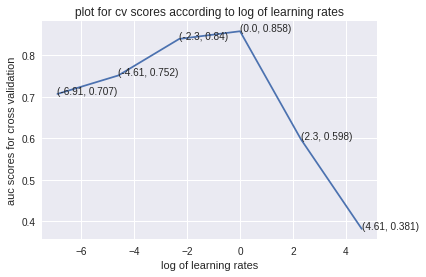

The auc score for each log of learning rates value for cross validation is :  [0.707 0.752 0.84  0.858 0.598 0.381]


In [40]:
plt.plot(log_lrs, CV_scores_lr)

plt.title('plot for cv scores according to log of learning rates')
for xy in zip(np.round(log_lrs, 2), np.round(CV_scores_lr,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log of learning rates')
plt.ylabel('auc scores for cross validation')
plt.show()

print("The auc score for each log of learning rates value for cross validation is : ", np.round(CV_scores_lr,3))

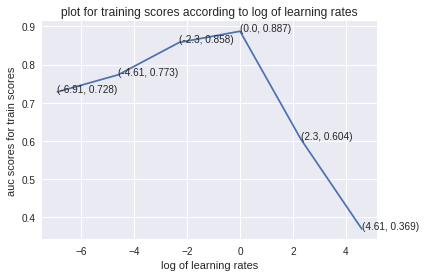

The auc score for each log of learning rates value for train data is :  [0.728 0.773 0.858 0.887 0.604 0.369]


In [41]:
plt.plot(log_lrs, train_scores_lr)

plt.title('plot for training scores according to log of learning rates')
for xy in zip(np.round(log_lrs, 2), np.round(train_scores_lr,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log of learning rates')
plt.ylabel('auc scores for train scores')
plt.show()

print("The auc score for each log of learning rates value for train data is : ", np.round(train_scores_lr,3))

In [0]:
def scores_for_estimators(X, Y):
    n_estimators=[10,20,40,50]
    scores =[]
    for n_estimator in tqdm(n_estimators):
            clf = GradientBoostingClassifier(loss='deviance', min_samples_split=10, min_samples_leaf=5, learning_rate=0.1, n_estimators=n_estimator)
            clf.fit(X_train_tfidfw2v, Y_train)
            pred = clf.predict_proba(X)[:, 1]
            auc = roc_auc_score(Y, pred)
            scores.append(auc)
    return scores

In [43]:
CV_scores_estimators = scores_for_estimators(X_CV_tfidfw2v, Y_CV)

100%|██████████| 4/4 [02:48<00:00, 41.67s/it]


In [44]:
train_scores_estimators = scores_for_estimators(X_train_tfidfw2v, Y_train)

100%|██████████| 4/4 [03:00<00:00, 44.70s/it]


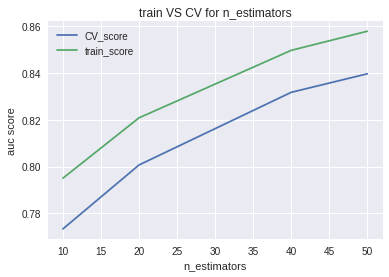

In [45]:
n_estimators=[10,20,40,50]
plt.plot(n_estimators, CV_scores_estimators, label='CV_score')
plt.plot(n_estimators, train_scores_estimators, label='train_score')
plt.title('train VS CV for n_estimators')
plt.ylabel('auc score')
plt.xlabel('n_estimators')
plt.legend()
plt.show()

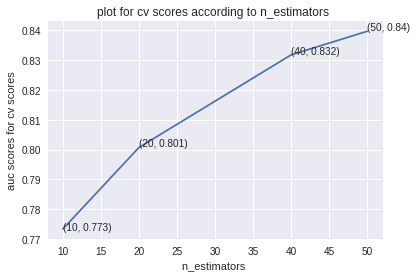

The auc score for each n_estimators  value for cv data is :  [0.773 0.801 0.832 0.84 ]


In [46]:
plt.plot(n_estimators, CV_scores_estimators)

plt.title('plot for cv scores according to n_estimators ')
for xy in zip(np.round(n_estimators, 2), np.round(CV_scores_estimators,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('n_estimators ')
plt.ylabel('auc scores for cv scores')
plt.show()

print("The auc score for each n_estimators  value for cv data is : ", np.round(CV_scores_estimators,3))

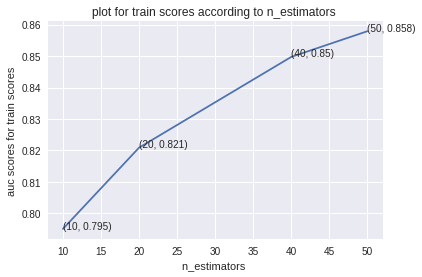

The auc score for each n_estimators  value for train data is :  [0.795 0.821 0.85  0.858]


In [47]:
plt.plot(n_estimators, train_scores_estimators)

plt.title('plot for train scores according to n_estimators ')
for xy in zip(np.round(n_estimators, 2), np.round(train_scores_estimators,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('n_estimators ')
plt.ylabel('auc scores for train scores')
plt.show()

print("The auc score for each n_estimators  value for train data is : ", np.round(train_scores_estimators,3))

## Visualizing the results in 3-D.

In [48]:
n_estimators=[10,20,40,50]
lrs = [10**-3,10**-2,10**-1,1,10,100]
scores_for_viz = []
estimator_during_looping = []
lr_during_looping = []
for estimator in tqdm(n_estimators):
  for lr in lrs:
      gbdt_model_for_viz = GradientBoostingClassifier(loss='deviance', min_samples_split=10, min_samples_leaf=5, learning_rate=lr, n_estimators=estimator)
      gbdt_model_for_viz.fit(X_train_tfidfw2v, Y_train)
      pred = gbdt_model_for_viz.predict_proba(X_CV_tfidfw2v)[:, 1] 
      auc = roc_auc_score(Y_CV, pred)
      scores_for_viz.append(auc)
      estimator_during_looping.append(estimator)
      lr_during_looping.append(lr)
      

100%|██████████| 4/4 [16:50<00:00, 249.62s/it]


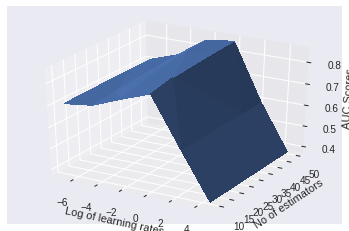

In [49]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Grab some test data.
X = np.log(np.asarray(lr_during_looping))
Y = np.asarray(estimator_during_looping)
Z = np.asarray(scores_for_viz)

# Plot a basic wireframe.
ax.plot_trisurf(X, Y, Z, linewidth=0, antialiased=False)
ax.set_xlabel('Log of learning rates')
ax.set_ylabel('No of estimators')
ax.set_zlabel('AUC Scores')


plt.show()

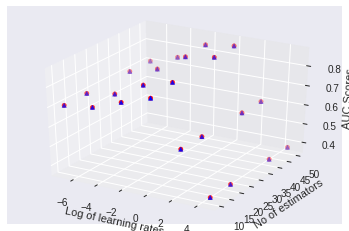

In [50]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, m, zlow, zhigh in [('r', 'o', -50, -25), ('b', '^', -30, -5)]:
    X = np.log(np.asarray(lr_during_looping))
    Y = np.asarray(estimator_during_looping)
    Z = np.asarray(scores_for_viz)
    ax.scatter(X, Y, Z, c=c, marker=m)

ax.set_xlabel('Log of learning rates')
ax.set_ylabel('No of estimators')
ax.set_zlabel('AUC Scores')

plt.show()

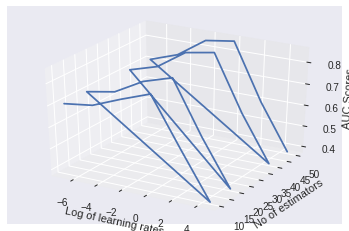

In [51]:
import matplotlib as mpl
mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure()
ax = fig.gca(projection='3d')
X = np.log(np.asarray(lr_during_looping))
Y = np.asarray(estimator_during_looping)
Z = np.asarray(scores_for_viz)
ax.plot(X, Y, Z, label='parametric curve')
ax.set_xlabel('Log of learning rates')
ax.set_ylabel('No of estimators')
ax.set_zlabel('AUC Scores')

plt.show()

## Getting the test data scores

In [0]:
gbdt_optimal = GradientBoostingClassifier(loss='deviance', min_samples_split=10, min_samples_leaf=5, learning_rate=0.1, n_estimators=50)

# fitting the model
gbdt_optimal.fit(X_train_tfidfw2v, Y_train)

# predict the response
pred = gbdt_optimal.predict(X_test_tfidfw2v)

# evaluate f1_score
fq_score = f1_score(Y_test, pred)

In [53]:
print('\nThe f1 score for test data for learning rate = {} and no of estimators = {} is {:2f}'.format(0.1, 50, fq_score))


The f1 score for test data for learning rate = 0.1 and no of estimators = 50 is 0.919454


## Visualizing the results.

In [54]:
conf_matrix = confusion_matrix(Y_test, pred)
conf_matrix

array([[  861,  5647],
       [  188, 33304]])

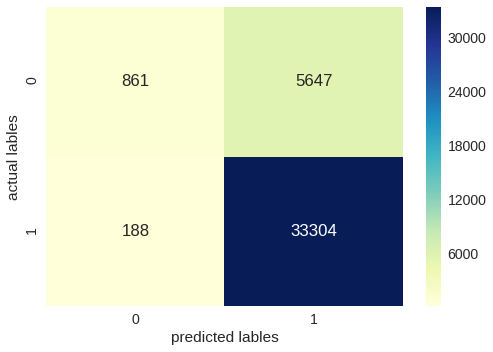

In [55]:
df_cm = pd.DataFrame(conf_matrix, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt="d",cmap="YlGnBu")
plt.xlabel('predicted lables')
plt.ylabel('actual lables')
plt.show()

In [56]:
print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

           0       0.82      0.13      0.23      6508
           1       0.86      0.99      0.92     33492

   micro avg       0.85      0.85      0.85     40000
   macro avg       0.84      0.56      0.57     40000
weighted avg       0.85      0.85      0.81     40000



# Comparison of all the models.

In [58]:
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Learning rate", "No of estimators", "f1-Score on the test data"]
x.add_row(['BOW', 'GBDT', 1, 50, '0.9375'])
x.add_row(['TF-IDF', 'GBDT', 1, 50, '0.9345'])
x.add_row(['Average W2V', 'GBDT', 0.1, 50, '0.9190'])
x.add_row(['TF-IDF Weighted W2V', 'GBDT', 0.1, 50, '0.9194'])
print(x)

+---------------------+-------+---------------+------------------+---------------------------+
|      Vectorizer     | Model | Learning rate | No of estimators | f1-Score on the test data |
+---------------------+-------+---------------+------------------+---------------------------+
|         BOW         |  GBDT |       1       |        50        |           0.9375          |
|        TF-IDF       |  GBDT |       1       |        50        |           0.9345          |
|     Average W2V     |  GBDT |      0.1      |        50        |           0.9190          |
| TF-IDF Weighted W2V |  GBDT |      0.1      |        50        |           0.9194          |
+---------------------+-------+---------------+------------------+---------------------------+


## Thus, from the above table we can see that the model with BOW vectorizer performed better.